In [4]:
import numpy as np
import pandas as pd
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
import lightgbm as lgb
import pickle
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot as plt
import seaborn as sns

In [128]:
application = pd.read_csv('./src/application_train.csv')
# application_test = pd.read_csv('./src/application_test.csv')
# application_test doesnt contain target column, it is useless to us because even if we develop a model, we still dont know its accuracy on the training set. 

In [36]:
bureau = pd.read_csv('./src/bureau.csv')

In [37]:
bureau_balance = pd.read_csv('./src/bureau_balance.csv')

In [38]:
credit_card_balance = pd.read_csv('./src/credit_card_balance.csv')

In [39]:
installments_payments = pd.read_csv('./src/installments_payments.csv')

In [40]:
POS_CASH_balance = pd.read_csv('./src/POS_CASH_balance.csv')
previous_application = pd.read_csv('./src/previous_application.csv')

In [10]:
home_credit_columns_description = pd.read_csv('./src/HomeCredit_columns_description.csv', encoding='iso-8859-1',
                                              index_col=0)

In [42]:
# sample_submission = pd.read_csv('./src/sample_submission.csv')

# Data preprocessing

In [43]:
application.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [44]:
# application.loc[:,['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]

In [11]:
home_credit_columns_description

Table                    Row  \
1    application_{train|test}.csv             SK_ID_CURR   
2    application_{train|test}.csv                 TARGET   
5    application_{train|test}.csv     NAME_CONTRACT_TYPE   
6    application_{train|test}.csv            CODE_GENDER   
7    application_{train|test}.csv           FLAG_OWN_CAR   
..                            ...                    ...   
217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
218     installments_payments.csv        DAYS_INSTALMENT   
219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
220     installments_payments.csv         AMT_INSTALMENT   
221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
1                             ID of loan in our sample   
2    Target variable (1 - client with payment diffi...   
5          Identification if loan is cash or revolving   
6                                 Gender of the client   
7                        Flag if the client owns a car   
..                                                 ...   
217            On which installment we observe payment   
218  When the installment of previous credit was su...   
219  When was the installments of previous credit p...   
220  What was the prescribed installment amount of ...   
221  What the client actually paid on previous cred...   

                                   Special  
1                                      NaN  
2                                      NaN  
5                                      NaN  
6                                      NaN  
7                                      NaN  
..                                     ...  
217                                    NaN  
218  time only relative to the application  
219  time only relative to the application  
220                                    NaN  
221                                    NaN  

[219 rows x 4 columns]

In [46]:
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

the SK_ID_CURR is the unique id for each client

In [47]:
len(application)

307511

In [48]:
len(bureau)

1716428

In [49]:
len(bureau_balance)

27299925

In [50]:
len(credit_card_balance)

3840312

In [51]:
len(installments_payments)

13605401

In [52]:
len(POS_CASH_balance)

10001358

In [53]:
len(previous_application)

1670214

## merge the bureau data with bureau_balance data (Kevin)

In [54]:
status_count = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack().fillna(0)
status_count.columns = ['BUREAU_BALANCE_' + str(col_name) for col_name in status_count.columns]
status_count.reset_index(inplace=True)
month_count = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min().abs().rename('BUREAU_BALANCE_MONTH_COUNT')
status_count = status_count.merge(month_count, how='left', on='SK_ID_BUREAU')  # add 0.001 to avoid divide by 0

In [55]:
# scale the status_count by month_count
for col in status_count.columns[1:-1]:
    status_count[col] = status_count[col] / (status_count['BUREAU_BALANCE_MONTH_COUNT'] + 1.001)

In [56]:
status_count.columns

Index(['SK_ID_BUREAU', 'BUREAU_BALANCE_0', 'BUREAU_BALANCE_1',
       'BUREAU_BALANCE_2', 'BUREAU_BALANCE_3', 'BUREAU_BALANCE_4',
       'BUREAU_BALANCE_5', 'BUREAU_BALANCE_C', 'BUREAU_BALANCE_X',
       'BUREAU_BALANCE_MONTH_COUNT'],
      dtype='object')

In [57]:
bureau = bureau.merge(status_count, how='left', on='SK_ID_BUREAU')

In [58]:
bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  ...  \
count        1.716428e+06    1.716415e+06         1.458759e+06  ...   
mean         6.410406e-03    3.549946e+05         1.370851e+05  ...   
std          9.622391e-02    1.149811e+06         6.774011e+05  ...   
min          0.000000e+00    0.000000e+00        -4.705600e+06  ...   
25%          0.000000e+00    5.130000e+04         0.000000e+00  ...   
50%          0.000000e+00    1.255185e+05         0.000000e+00  ...   
75%          0.000000e+00    3.150000e+05         4.015350e+04  ...   
max          9.000000e+00    5.850000e+08         1.701000e+08  ...   

        AMT_ANNUITY  BUREAU_BALANCE_0  BUREAU_BALANCE_1  BUREAU_BALANCE_2  \
count  4.896370e+05     774354.000000     774354.000000     774354.000000   
mean   1.571276e+04          0.351976          0.009966          0.000683   
std    3.258269e+05          0.328245          0.042879          0.007975   
min    0.000000e+00          0.000000          0.000000          0.000000   
25%    0.000000e+00          0.079545          0.000000          0.000000   
50%    0.000000e+00          0.239990          0.000000          0.000000   
75%    1.350000e+04          0.580240          0.000000          0.000000   
max    1.184534e+08          0.999989          0.999923          0.714184   

       BUREAU_BALANCE_3  BUREAU_BALANCE_4  BUREAU_BALANCE_5  BUREAU_BALANCE_C  \
count     774354.000000     774354.000000     774354.000000     774354.000000   
mean           0.000236          0.000154          0.001295          0.327617   
std            0.003747          0.002875          0.024694          0.358784   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.160492   
75%            0.000000          0.000000          0.000000          0.692281   
max            0.399920          0.499875          0.999974          0.999990   

       BUREAU_BALANCE_X  BUREAU_BALANCE_MONTH_COUNT  
count     774354.000000               774354.000000  
mean           0.192275                   36.288669  
std            0.320677                   25.449736  
min            0.000000                    0.000000  
25%            0.000000                   15.000000  
50%            0.019607                   31.000000  
75%            0.230751                   53.000000  
max            0.999990                   96.000000  

[8 rows x 23 columns]

## Cleaning bureau data (Kevin)

In [59]:
# print number of unique item in each column
for col in bureau.columns:
    print(col, 'Unique item:', len(bureau[col].unique()), 'NA:', len(bureau.loc[bureau[col].isnull()]), 'value=0:',
          len(bureau.loc[bureau[col] == 0]))

SK_ID_CURR Unique item: 305811 NA: 0 value=0: 0
SK_ID_BUREAU Unique item: 1716428 NA: 0 value=0: 0
CREDIT_ACTIVE Unique item: 4 NA: 0 value=0: 0
CREDIT_CURRENCY Unique item: 4 NA: 0 value=0: 0
DAYS_CREDIT Unique item: 2923 NA: 0 value=0: 25
CREDIT_DAY_OVERDUE Unique item: 942 NA: 0 value=0: 1712211
DAYS_CREDIT_ENDDATE Unique item: 14097 NA: 105553 value=0: 883
DAYS_ENDDATE_FACT Unique item: 2918 NA: 633653 value=0: 64
AMT_CREDIT_MAX_OVERDUE Unique item: 68252 NA: 1124488 value=0: 470650
CNT_CREDIT_PROLONG Unique item: 10 NA: 0 value=0: 1707314
AMT_CREDIT_SUM Unique item: 236709 NA: 13 value=0: 66582
AMT_CREDIT_SUM_DEBT Unique item: 226538 NA: 257669 value=0: 1016434
AMT_CREDIT_SUM_LIMIT Unique item: 51727 NA: 591780 value=0: 1050142
AMT_CREDIT_SUM_OVERDUE Unique item: 1616 NA: 0 value=0: 1712270
CREDIT_TYPE Unique item: 15 NA: 0 value=0: 0
DAYS_CREDIT_UPDATE Unique item: 2982 NA: 0 value=0: 605
AMT_ANNUITY Unique item: 40322 NA: 1226791 value=0: 256915
BUREAU_BALANCE_0 Unique item: 463

In [60]:
# def aggregate_do_nothing(bureau, col):
#     res = bureau[col]
#     return res.reindex(application['SK_ID_CURR']).fillna(0).rename('BUREAU_' + col)

In [61]:
def aggregate_count(bureau, col, name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].count()
    res = bureau.groupby('SK_ID_CURR')[col].count()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(name + '_' + col + '_COUNT')

In [62]:
def aggregate_categorical(df, col, name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = df.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name + '_' + col + '_' + str(col_name) for col_name in res.columns]
    return res

In [63]:
def aggregate_avg_max_min_std_skw(df, col, name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = df.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name + '_' + col + '_' + col_name for col_name in res.columns]
    return res

In [64]:
def aggregate_avg_max_min_std_skw_nan_count(df, col, name):
    res = df.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    # count the number of nan
    res['nan_count'] = df.groupby('SK_ID_CURR')[col].apply(lambda x: x.isnull().sum())
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name + '_' + col + '_' + col_name for col_name in res.columns]

    return res

In [65]:
bureau_agg_dic = {'SK_ID_BUREAU': 'aggregate_count',
                  'CREDIT_ACTIVE': 'aggregate_categorical',
                  'CREDIT_CURRENCY': 'aggregate_categorical',
                  'DAYS_CREDIT': 'aggregate_avg_max_min_std_skw',
                  'CREDIT_DAY_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_ENDDATE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'DAYS_ENDDATE_FACT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_MAX_OVERDUE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'CNT_CREDIT_PROLONG': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM_DEBT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_LIMIT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_UPDATE': 'aggregate_avg_max_min_std_skw',
                  'AMT_ANNUITY': 'aggregate_avg_max_min_std_skw_nan_count',
                  'BUREAU_BALANCE_0': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_1': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_2': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_3': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_4': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_5': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_C': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_X': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_MONTH_COUNT': 'aggregate_avg_max_min_std_skw'}

In [67]:
# parallel processing
bureau_merging_result = Parallel(n_jobs=4)(
    delayed(eval(bureau_agg_dic[col]))(bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])], col, 'BUREAU') for
    col in
    bureau_agg_dic.keys())  # 6min

In [68]:
# merge all the result on SK_ID_CURR
bureau_merging_result = pd.concat(bureau_merging_result, axis=1)

## Cleaning POS Cash data (Grace)

In [69]:
# count for how many credit cart one have
def POS_CASH_count(POS_CASH_balance):
    return POS_CASH_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].count().rename('POS_CASH_SK_ID_PREV_COUNT').reindex(
        application['SK_ID_CURR']).fillna(0)

In [70]:
def contract_status(POS_CASH_balance):
    # one hot encode the NAME_CONTRACT_STATUS
    dum = pd.get_dummies(POS_CASH_balance['NAME_CONTRACT_STATUS'])
    for col in dum:
        dum[col] = dum[col] * (1 - POS_CASH_balance['CNT_INSTALMENT_FUTURE'] / POS_CASH_balance['CNT_INSTALMENT'])
    dum.columns = ['POS_CASH_' + str(col_name) for col_name in dum.columns]
    return POS_CASH_balance.loc[:, ['SK_ID_PREV', 'SK_ID_CURR', ]].join(dum).groupby(
        ['SK_ID_CURR', 'SK_ID_PREV']).max().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0)

In [71]:
def earliest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].min().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_EARLIEST_STARTING')


def latest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_LATEST_STARTING')

In [72]:
def cnt_installment_min_max_skew_count(POS_CASH_balance):
    res = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT'].first()
    res = res.groupby('SK_ID_CURR').agg(['min', 'max', 'skew', 'count'])
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': 'POS_CASH_CNT_INSTALMENT_MIN',
                                                                            'max': 'POS_CASH_CNT_INSTALMENT_MAX',
                                                                            'skew': 'POS_CASH_CNT_INSTALMENT_SKEW',
                                                                            'count': 'POS_CASH_CNT_INSTALMENT_COUNT'})

In [73]:
def max_col_min_max_avg_skew_count(POS_CASH_balance, col):
    tmp = POS_CASH_balance.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[col].max()
    res = tmp.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'skew'])
    res['nonzero_count'] = tmp.groupby('SK_ID_CURR').apply(lambda x: (x != 0).sum())
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': 'POS_CASH_MAX_' + col + '_MIN',
                                                                            'max': 'POS_CASH_MAX_' + col + '_MAX',
                                                                            'mean': 'POS_CASH_MAX_' + col + '_MEAN',
                                                                            'skew': 'POS_CASH_MAX_' + col + '_SKEW',
                                                                            'nonzero_count': 'POS_CASH_MAX_' + col + '_NON_0_COUNT'})

In [76]:
pos_cash_balance_function_list = [POS_CASH_count,
                                  contract_status,
                                  earliest_starting,
                                  latest_starting,
                                  cnt_installment_min_max_skew_count]
max_col_process_list = ['SK_DPD', 'SK_DPD_DEF']
POS_CASH_balance_merging_res = pd.concat([func(POS_CASH_balance) for func in tqdm(pos_cash_balance_function_list)]
                                         + [max_col_min_max_avg_skew_count(POS_CASH_balance, col_name) for col_name in
                                            tqdm(max_col_process_list)], axis=1)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.64it/s]

 40%|████      | 2/5 [00:09<00:16,  5.50s/it]

 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

 80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

100%|██████████| 5/5 [01:20<00:00, 16.14s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:20<02:20, 140.59s/it]

100%|██████████| 2/2 [04:49<00:00, 144.90s/it]


In [77]:
POS_CASH_balance_merging_res.shape

(307511, 26)

## Cleaning Credit card data (Evelyne)

In [78]:
# count for how many credit cart one have
def prev_count(df: pd.DataFrame, col: str, name: str):
    return df.groupby('SK_ID_CURR')[col].count().rename(f"{name}_{col}_COUNT").reindex(
        application['SK_ID_CURR']).fillna(0)

In [79]:
def prev_aggregate_categorical(df, col, name):
    """first do value counts at previous id level, then do the same transformation at current id level"""
    res = pd.get_dummies(df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].value_counts().unstack().fillna(0))
    # aggregate by sum
    res = res.groupby('SK_ID_CURR').sum()
    res.columns = [name + '_' + col + '_' + str(col_name) for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [80]:
def prev_aggregate_max_sum(df, col, name):
    """first do max at previous id level, then do the sum at current id level"""
    res = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].max()
    res = res.groupby('SK_ID_CURR').sum()
    res.columns = [name + '_' + col + '_MAX_SUM']
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [81]:
def prev_aggregate_sum_mean_min_max(df, col, name):
    """first do sum mean min max at previous id level, then do the same transformation at current id level"""
    res = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['sum', 'mean', 'min', 'max']).reset_index()
    res = res.groupby('SK_ID_CURR').agg({'sum': 'sum', 'mean': 'mean', 'min': 'min', 'max': 'max'})
    res.columns = [name + '_' + col + '_' + col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [82]:
def prev_aggregate_sum_mean_min_max_zero_count(creditcard, col, name):
    """first do min max sum zero count at previous id level, then do the same transformation at current id level"""
    res = creditcard.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['min', 'max', 'sum', 'mean'])
    res['zero_count'] = creditcard.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].apply(lambda x: (x == 0).sum())
    res = res.groupby('SK_ID_CURR').agg(
        {'min': 'min', 'max': 'max', 'sum': 'sum', 'mean': 'mean', 'zero_count': 'mean'})
    res.columns = [name + '_' + col + '_' + col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)


In [83]:
def prev_aggregate_max_col_min_max_avg_skew_count(df, col, name):
    tmp = df.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[col].max()
    res = tmp.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'skew'])
    res['nonzero_count'] = tmp.groupby('SK_ID_CURR').apply(lambda x: (x != 0).sum())
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': name + '_MAX_' + col + '_MIN',
                                                                            'max': name + '_MAX_' + col + '_MAX',
                                                                            'mean': name + '_MAX_' + col + '_MEAN',
                                                                            'skew': name + '_MAX_' + col + '_SKEW',
                                                                            'nonzero_count': name + '_MAX_' + col + '_NON_0_COUNT'})

In [84]:
cc_aggregate_dic = {
    'SK_ID_PREV': 'prev_count',
    'AMT_BALANCE': 'prev_aggregate_sum_mean_min_max',
    # take transformation at card level then same transformation for current id
    'AMT_CREDIT_LIMIT_ACTUAL': 'prev_aggregate_max_sum',  # take max at card level then sum for current id
    'AMT_DRAWINGS_ATM_CURRENT': 'prev_aggregate_sum_mean_min_max_zero_count',  # count the number of 0 atm drawings
    'AMT_DRAWINGS_CURRENT': 'prev_aggregate_sum_mean_min_max_zero_count',  # count the number of 0 drawings
    'AMT_DRAWINGS_POS_CURRENT': 'prev_aggregate_sum_mean_min_max_zero_count',  # count the number of 0 pos drawings
    'AMT_DRAWINGS_OTHER_CURRENT': 'prev_aggregate_sum_mean_min_max_zero_count',  # count the number of 0 other drawings
    'AMT_INST_MIN_REGULARITY': 'prev_aggregate_sum_mean_min_max_zero_count',
    # count the number of 0 for not needing to pay installment
    'AMT_PAYMENT_CURRENT': 'prev_aggregate_max_sum',  # take the max then sum among cards. instant payment ability
    'AMT_PAYMENT_TOTAL_CURRENT': 'prev_aggregate_max_sum',  # take the max then sum among cards. total payment ability
    'AMT_RECEIVABLE_PRINCIPAL': 'prev_aggregate_sum_mean_min_max',
    # take transformation at card level then same transformation for current id
    'AMT_RECIVABLE': 'prev_aggregate_sum_mean_min_max',
    # take transformation at card level then same transformation for current id
    'AMT_TOTAL_RECEIVABLE': 'prev_aggregate_sum_mean_min_max',
    # take transformation at card level then same transformation for current id
    'CNT_DRAWINGS_ATM_CURRENT': 'prev_aggregate_max_sum',  # take the max then sum among cards. max atm drawings
    'CNT_DRAWINGS_CURRENT': 'prev_aggregate_max_sum',  # take the max then sum among cards. max drawings
    'CNT_DRAWINGS_POS_CURRENT': 'prev_aggregate_max_sum',  # take the max then sum among cards. max pos drawings
    'CNT_INSTALMENT_MATURE_CUM': 'prev_aggregate_max_sum',
    # take the max then sum among cards. max installment mature cum
    'NAME_CONTRACT_STATUS': 'prev_aggregate_categorical',
    # take value counts at card level then same transformation for current id
    'SK_DPD': 'prev_aggregate_max_col_min_max_avg_skew_count',  # count the number of 0 dpd
    'SK_DPD_DEF': 'prev_aggregate_max_col_min_max_avg_skew_count'  # count the number of 0 dpd def
}

In [85]:
credit_card_balance_merging_res = Parallel(n_jobs=4)(
    delayed(eval(cc_aggregate_dic[col]))(credit_card_balance, col, 'CC') for col in tqdm(cc_aggregate_dic.keys()))



  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:03<00:05,  2.34it/s]

 60%|██████    | 12/20 [00:35<00:28,  3.55s/it]

 80%|████████  | 16/20 [00:38<00:10,  2.53s/it]

100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


In [86]:
credit_card_balance_merging_res = pd.concat(credit_card_balance_merging_res, axis=1)


In [87]:
credit_card_balance_merging_res.shape

(307511, 66)

## Cleaning Installment data (Kai)

In [88]:
def prev_aggregate_nunique(df, col, name):
    res = df.groupby('SK_ID_CURR')[col].nunique()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(name + '_' + col + '_nunique')

In [89]:
def prev_aggregate_diff_sum_mean_min_max_zero_larger_count(df, col1, col2, name):
    res = df.loc[:, ['SK_ID_CURR', 'SK_ID_PREV']].copy()
    res['diff'] = df[col1] - df[col2]
    res['zero_larger'] = res['diff'].apply(lambda x: 1 if x >= 0 else 0)
    res = res.groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg(
        {'diff': ['sum', 'mean', 'min', 'max', 'skew'], 'zero_larger': 'sum'})
    res.columns = res.columns.get_level_values(0) + '_' + res.columns.get_level_values(1)
    res = res.groupby('SK_ID_CURR').agg(
        {'diff_sum': 'sum', 'diff_mean': 'mean', 'diff_min': 'min', 'diff_max': 'max', 'diff_skew': 'skew',
         'zero_larger_sum': 'sum'})
    res.columns = [name + '_' + col1 + '_' + col2 + '_' + col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [90]:
# prev_aggregate_diff_sum_mean_min_max_zero_larger_count(installments_payments,'DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','INS')

In [91]:
ins_aggregate_dic = {
    'SK_ID_PREV': 'prev_count',
    'NUM_INSTALMENT_VERSION': 'prev_aggregate_nunique',
    'DAYS_INSTALMENT': 'prev_aggregate_sum_mean_min_max_zero_count',
    'DAYS_ENTRY_PAYMENT': 'prev_aggregate_sum_mean_min_max_zero_count',
    'AMT_INSTALMENT': 'prev_aggregate_sum_mean_min_max',  # there is no 0 installment
    'AMT_PAYMENT': 'prev_aggregate_sum_mean_min_max',  # there is no 0 installment
}
ins_aggregate_diff_dic = {
    'DAYS_INSTALMENT': 'DAYS_ENTRY_PAYMENT',
    'AMT_INSTALMENT': 'AMT_PAYMENT',
}

In [92]:
installments_payments_merging_res = Parallel(n_jobs=4)(
    delayed(eval(ins_aggregate_dic[col]))(installments_payments, col, 'INS') for col in tqdm(ins_aggregate_dic.keys()))
installments_payments_merging_res += Parallel(n_jobs=4)(
    delayed(prev_aggregate_diff_sum_mean_min_max_zero_larger_count)(installments_payments, col1, col2, 'INS') for
    col1, col2 in tqdm(ins_aggregate_diff_dic.items()))



100%|██████████| 6/6 [00:00<00:00, 2999.86it/s]


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


In [93]:
installments_payments_merging_res = pd.concat(installments_payments_merging_res, axis=1)

In [94]:
installments_payments_merging_res.shape

(307511, 32)

## Cleaning Previous application data (Nicola)

In [95]:
def prev_aggregate_min_max_sum_mean_NA_count(df, col, name):
    if 'DAYS' in col:
        # fixing the na as 365243 problem
        res = df.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', col]].copy()
        res = res.replace(365243, np.nan)
    else:
        res = df.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', col]].copy()
    res = res.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['min', 'max', 'sum', 'mean'])
    res['NA_count'] = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].apply(lambda x: x.isnull().sum())
    res = res.groupby('SK_ID_CURR').agg({'min': 'min', 'max': 'max', 'sum': 'sum', 'mean': 'mean', 'NA_count': 'mean'})
    res.columns = [name + '_' + col + '_' + col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [96]:
def prev_aggregate_workday_weekend(df, col, name):
    res = pd.DataFrame(df.loc[:, 'SK_ID_CURR']).join(pd.get_dummies(df[col].apply(
        lambda x: 'Workday' if x in ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY'] else 'Weekend')))
    res = res.groupby('SK_ID_CURR').sum()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(
        columns={0: name + '_' + col + '_Weekend', 1: name + '_' + col + '_Workday'})

In [97]:
def prev_aggregate_hours_of_day(df, col, name):
    res = pd.DataFrame(df.loc[:, 'SK_ID_CURR']).join(
        pd.get_dummies(df[col].apply(lambda x: 'morning' if x > 12 else 'afternoon')))
    res = res.groupby('SK_ID_CURR').sum()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(
        columns={0: name + '_' + col + '_afternoon', 1: name + '_' + col + '_morning'})

In [98]:
prev_app_aggregate_dic = {
    'SK_ID_PREV': 'prev_count',
    'NAME_CONTRACT_TYPE': 'prev_aggregate_categorical',
    'AMT_ANNUITY': 'prev_aggregate_sum_mean_min_max',
    'AMT_APPLICATION': 'prev_aggregate_sum_mean_min_max',
    'AMT_CREDIT': 'prev_aggregate_sum_mean_min_max',
    'AMT_DOWN_PAYMENT': 'prev_aggregate_min_max_sum_mean_NA_count',
    'AMT_GOODS_PRICE': 'prev_aggregate_sum_mean_min_max',
    'WEEKDAY_APPR_PROCESS_START': 'prev_aggregate_workday_weekend',
    'HOUR_APPR_PROCESS_START': 'prev_aggregate_hours_of_day',
    'FLAG_LAST_APPL_PER_CONTRACT': 'prev_aggregate_categorical',
    # 'NFLAG_LAST_APPL_IN_DAY':'prev_aggregate_categorical',# we dont want this: error in system, 3% difference
    'RATE_DOWN_PAYMENT': 'prev_aggregate_min_max_sum_mean_NA_count',
    'RATE_INTEREST_PRIMARY': 'prev_aggregate_min_max_sum_mean_NA_count',
    'RATE_INTEREST_PRIVILEGED': 'prev_aggregate_min_max_sum_mean_NA_count',
    'NAME_CASH_LOAN_PURPOSE': 'prev_aggregate_categorical',
    'NAME_CONTRACT_STATUS': 'prev_aggregate_categorical',
    'DAYS_DECISION': 'prev_aggregate_min_max_sum_mean_NA_count',
    'NAME_PAYMENT_TYPE': 'prev_aggregate_categorical',
    'CODE_REJECT_REASON': 'prev_aggregate_categorical',
    'NAME_TYPE_SUITE': 'prev_aggregate_categorical',
    'NAME_CLIENT_TYPE': 'prev_aggregate_categorical',
    'NAME_GOODS_CATEGORY': 'prev_aggregate_categorical',
    'NAME_PORTFOLIO': 'prev_aggregate_categorical',
    'NAME_PRODUCT_TYPE': 'prev_aggregate_categorical',
    'CHANNEL_TYPE': 'prev_aggregate_categorical',
    'SELLERPLACE_AREA': 'prev_aggregate_sum_mean_min_max',
    'NAME_SELLER_INDUSTRY': 'prev_aggregate_categorical',
    'CNT_PAYMENT': 'prev_aggregate_sum_mean_min_max',
    'NAME_YIELD_GROUP': 'prev_aggregate_categorical',
    'PRODUCT_COMBINATION': 'prev_aggregate_categorical',
    'DAYS_FIRST_DRAWING': 'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_FIRST_DUE': 'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_LAST_DUE_1ST_VERSION': 'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_LAST_DUE': 'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_TERMINATION': 'prev_aggregate_min_max_sum_mean_NA_count',
    'NFLAG_INSURED_ON_APPROVAL': 'prev_aggregate_categorical',
}
prev_app_aggregate_diff_dic = {
    'AMT_APPLICATION': 'AMT_CREDIT',
    'AMT_APPLICATION': 'AMT_GOODS_PRICE',

}

In [99]:
previous_application_merging_res = Parallel(n_jobs=4)(
    delayed(eval(prev_app_aggregate_dic[col]))(previous_application, col, 'PREV_APP') for col in
    tqdm(prev_app_aggregate_dic.keys()))
previous_application_merging_res += Parallel(n_jobs=4)(
    delayed(prev_aggregate_diff_sum_mean_min_max_zero_larger_count)(previous_application, col1, col2, 'PREV_APP') for
    col1, col2 in tqdm(prev_app_aggregate_diff_dic.items()))



  0%|          | 0/35 [00:00<?, ?it/s]

 23%|██▎       | 8/35 [00:05<00:19,  1.40it/s]

 34%|███▍      | 12/35 [00:15<00:34,  1.48s/it]

 46%|████▌     | 16/35 [00:27<00:37,  1.98s/it]

 57%|█████▋    | 20/35 [07:08<09:02, 36.16s/it]

 69%|██████▊   | 24/35 [07:20<04:36, 25.18s/it]

 80%|████████  | 28/35 [07:30<02:05, 17.89s/it]

 83%|████████▎ | 29/35 [07:32<01:37, 16.24s/it]

100%|██████████| 35/35 [07:42<00:00, 13.22s/it]


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


In [100]:
previous_application_merging_res = pd.concat(previous_application_merging_res, axis=1)

In [101]:
previous_application_merging_res.shape

(307511, 223)

## Cleaning Application data (Kevin)

In [179]:
application

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [180]:
def aggregate_flag(df, col, name):
    """ONLY use for binary flag, transfer to 1 and 0"""
    assert len(df[col].unique()) == 2
    one_name = df[col].unique()[0]
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x == one_name else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name + '_' + col})

In [181]:
def do_nothing(df, col, name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    if 'DAYS' in col:
        res[col].replace(365243, np.nan, inplace=True)
        res[col].replace(0, np.nan, inplace=True)
        res[name + '_' + col + '_NAN_FLAG'] = res[col].apply(lambda x: 1 if np.isnan(x) else 0)
    res[col] = res[col].fillna(0)
    res.rename(columns={col: name + '_' + col}, inplace=True)

    return res.set_index('SK_ID_CURR')

In [182]:
def aggregate_workday_weekend(df, col, name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x in ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY'] else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name + '_' + col + '_Workday_FLAG'})


In [183]:
def aggregate_hour_of_day(df, col, name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x > 12 else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name + '_' + col + '_Morning_FLAG'})

In [184]:
aggregate_flag(application, 'NAME_CONTRACT_TYPE', 'APP')

APP_NAME_CONTRACT_TYPE
SK_ID_CURR                        
100002                           1
100003                           1
100004                           0
100006                           1
100007                           1
...                            ...
456251                           1
456252                           1
456253                           1
456254                           1
456255                           1

[307511 rows x 1 columns]

In [185]:
aggregate_workday_weekend(application, 'WEEKDAY_APPR_PROCESS_START', 'APP')

APP_WEEKDAY_APPR_PROCESS_START_Workday_FLAG
SK_ID_CURR                                             
100002                                                1
100003                                                1
100004                                                1
100006                                                1
100007                                                1
...                                                 ...
456251                                                1
456252                                                1
456253                                                1
456254                                                1
456255                                                1

[307511 rows x 1 columns]

In [186]:
application['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [187]:
application_cleaning_dic = {
    'NAME_CONTRACT_TYPE': 'aggregate_flag',
    'CODE_GENDER': 'aggregate_categorical',
    'FLAG_OWN_CAR': 'aggregate_flag',
    'FLAG_OWN_REALTY': 'aggregate_flag',
    'NAME_TYPE_SUITE': 'aggregate_categorical',
    'NAME_INCOME_TYPE': 'aggregate_categorical',
    'NAME_EDUCATION_TYPE': 'aggregate_categorical',
    'NAME_FAMILY_STATUS': 'aggregate_categorical',
    'NAME_HOUSING_TYPE': 'aggregate_categorical',
    'FLAG_MOBIL': 'aggregate_flag',
    'FLAG_EMP_PHONE': 'aggregate_flag',
    'FLAG_WORK_PHONE': 'aggregate_flag',
    'FLAG_CONT_MOBILE': 'aggregate_flag',
    'FLAG_PHONE': 'aggregate_flag',
    'FLAG_EMAIL': 'aggregate_flag',
    'OCCUPATION_TYPE': 'aggregate_categorical',
    'WEEKDAY_APPR_PROCESS_START': 'aggregate_workday_weekend',
    'HOUR_APPR_PROCESS_START': 'aggregate_hour_of_day',
    'REG_REGION_NOT_LIVE_REGION': 'aggregate_flag',
    'REG_REGION_NOT_WORK_REGION': 'aggregate_flag',
    'LIVE_REGION_NOT_WORK_REGION': 'aggregate_flag',
    'REG_CITY_NOT_LIVE_CITY': 'aggregate_flag',
    'REG_CITY_NOT_WORK_CITY': 'aggregate_flag',
    'LIVE_CITY_NOT_WORK_CITY': 'aggregate_flag',
    'ORGANIZATION_TYPE': 'aggregate_categorical',
    'FONDKAPREMONT_MODE': 'aggregate_categorical',
    'HOUSETYPE_MODE': 'aggregate_categorical',
    'WALLSMATERIAL_MODE': 'aggregate_categorical',
    'EMERGENCYSTATE_MODE': 'aggregate_categorical',

}
application_do_nothing_list = [
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ELEVATORS_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    # "FONDKAPREMONT_MODE",
    # "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    # "WALLSMATERIAL_MODE",
    # "EMERGENCYSTATE_MODE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
]

In [188]:
application_merging_res = Parallel(n_jobs=4)(
    delayed(eval(application_cleaning_dic[col]))(application, col, 'APP') for col in
    tqdm(application_cleaning_dic.keys()))
application_merging_res += Parallel(n_jobs=4)(
    delayed(do_nothing)(application, col, 'APP') for col in tqdm(application_do_nothing_list))

100%|██████████| 91/91 [00:20<00:00,  4.52it/s]


In [189]:
application_merging_res = pd.concat(application_merging_res, axis=1)

In [190]:
application_merging_res.shape

(307511, 240)

# Merge cleaned data

In [191]:
cleaned_data = pd.concat([application_merging_res, previous_application_merging_res, installments_payments_merging_res,
                          credit_card_balance_merging_res, POS_CASH_balance_merging_res, bureau_merging_result,
                          application.loc[:, ['SK_ID_CURR', 'TARGET']].set_index('SK_ID_CURR')], axis=1)

In [192]:
import re

cleaned_data = cleaned_data.rename(
    columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))  # remove special characters in feature name

In [193]:
cleaned_data.shape

(307511, 708)

In [194]:
cleaned_data.to_csv('./src/cleaned_data.csv')

In [195]:
cleaned_data = pd.read_csv('./src/cleaned_data.csv', index_col=0)

In [196]:
cleaned_data.shape

(307511, 709)

# Feature engineering

In [5]:
cleaned_data = pd.read_csv('./src/cleaned_data.csv', index_col=0)

In [6]:
def mutual_info(data,sort = False,pairwise_corr = True,figsize=(11, 9),clustermap = False):
    X_list= data.columns
    if len(X_list) == 1:
        res = mutual_info_classif(data[X_list[0]].values.reshape(-1, 1), cleaned_data['TARGET'], random_state=42)
    else:
        res = mutual_info_classif(data.loc[:, X_list], cleaned_data['TARGET'], random_state=42)
    
    if clustermap:
        #plot clustermap
        corr = data.corr(method='kendall')
        # mask = np.triu(np.ones_like(corr, dtype=bool))
        # f, ax = plt.subplots(figsize=figsize)
        # cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # using same color for large correlation both positive and negative
        # cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # include number in the heatmap
        # sns.clustermap(corr, cmap='RdYlGn',mask=mask, vmax=1, vmin=-1, center=0,
        #              linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
        sns.clustermap(corr, cmap='RdYlGn', vmax=1, vmin=-1, center=0,
                     linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f',row_cluster=False)
        plt.title('Pairwise Correlation Clustermap')
        plt.show()
        pairwise_corr = False
    
    if pairwise_corr:
        #plot heatmap
        corr = data.corr(method='kendall')
        mask = np.triu(np.ones_like(corr, dtype=bool))
        f, ax = plt.subplots(figsize=figsize)
        # cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # using same color for large correlation both positive and negative
        # cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # include number in the heatmap
        sns.heatmap(corr, cmap='RdYlGn',mask=mask, vmax=1, vmin=-1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
        plt.title('Pairwise Correlation Heatmap')
        plt.show()
    
    if sort:
        return pd.DataFrame(res, index=X_list, columns=['mutual_info_with_target']).sort_values('mutual_info_with_target',
                                                                                            ascending=False)
    else:
        return pd.DataFrame(res, index=X_list, columns=['mutual_info_with_target'])

## APP_EXT_SOURCE_3, APP_EXT_SOURCE_1 (Kevin)

### source_1_3_zero

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


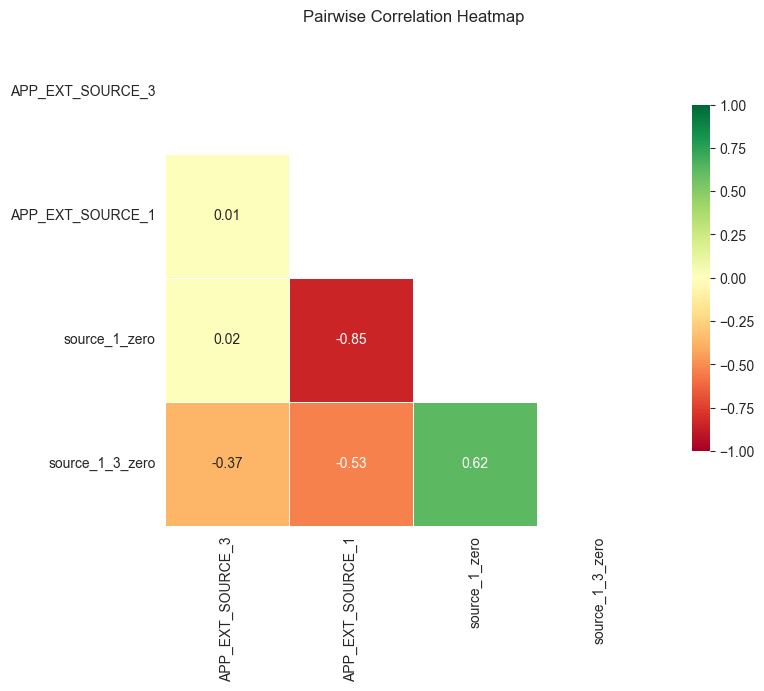

mutual_info_with_target
APP_EXT_SOURCE_3                 0.013413
APP_EXT_SOURCE_1                 0.005776
source_1_zero                    0.047620
source_1_3_zero                  0.012182

In [7]:
tmp = cleaned_data.loc[:, ['APP_EXT_SOURCE_3',
                                 'APP_EXT_SOURCE_1']]
tmp['source_1_zero'] = tmp['APP_EXT_SOURCE_1'].apply(lambda x: 1 if x == 0 else 0)
# tmp['source_3_zero']=tmp['APP_EXT_SOURCE_3'].apply(lambda x: 1 if x==0 else 0)
tmp['source_1_3_zero'] = (tmp['APP_EXT_SOURCE_1'].apply(lambda x: 1 if x == 0 else 0)/tmp['APP_EXT_SOURCE_1'].value_counts()[0])+ (tmp[
    'APP_EXT_SOURCE_3'].apply(lambda x: 1 if x == 0 else 0)/tmp['APP_EXT_SOURCE_3'].value_counts()[0])

mutual_info(tmp,figsize=(8,9))

## APP_DAYS_BIRTH, APP_DAYS_REGISTRATION, APP_DAYS_ID_PUBLISH, APP_DAYS_LAST_PHONE_CHANGE (Kevin)

### unstable registration

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


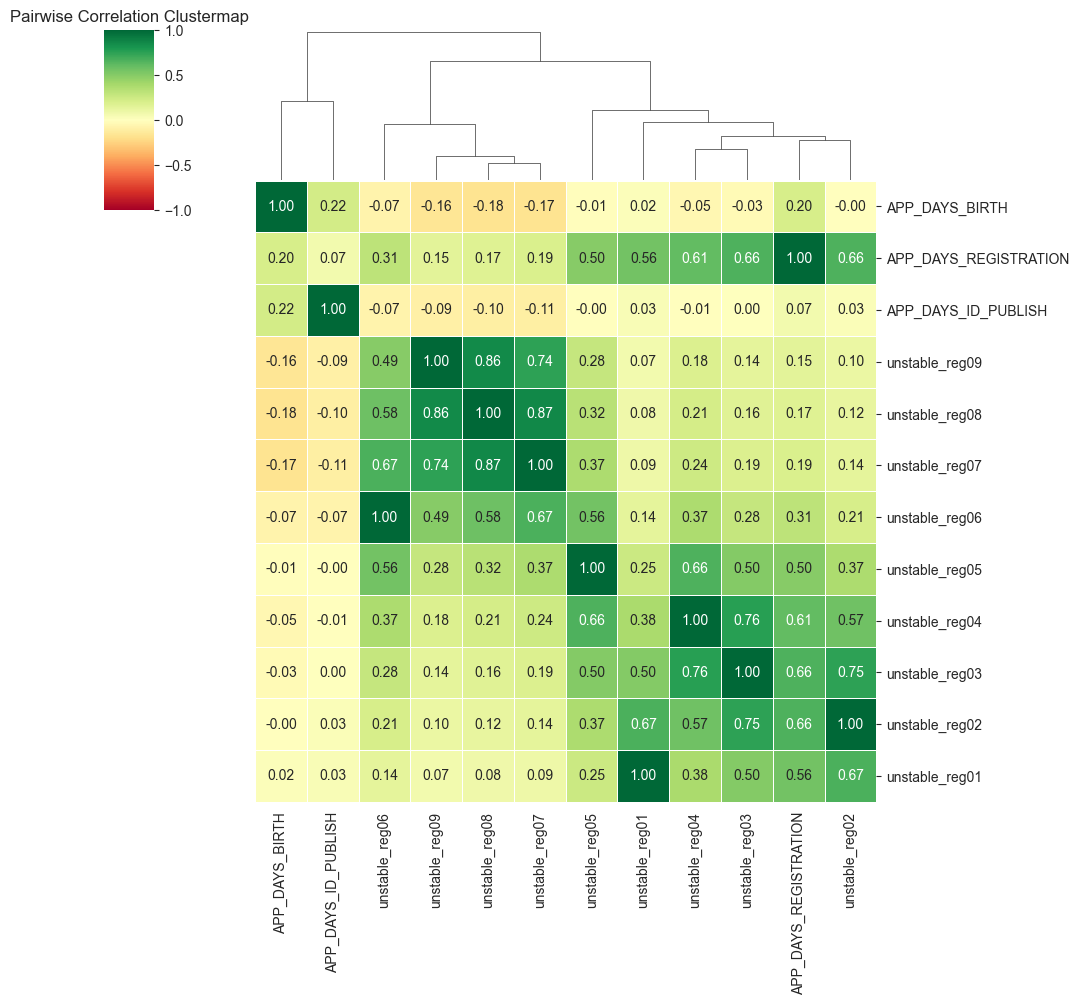

mutual_info_with_target
APP_DAYS_BIRTH                        0.003285
APP_DAYS_REGISTRATION                 0.001449
APP_DAYS_ID_PUBLISH                   0.002793
unstable_reg09                        0.046385
unstable_reg08                        0.053635
unstable_reg07                        0.059838
unstable_reg06                        0.041292
unstable_reg05                        0.055122
unstable_reg04                        0.053024
unstable_reg03                        0.042280
unstable_reg02                        0.021872
unstable_reg01                        0.007452

In [8]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH']]
tmp['unstable_reg09']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.9).astype(int)
tmp['unstable_reg08']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.8).astype(int)
tmp['unstable_reg07']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.7).astype(int)
tmp['unstable_reg06']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.6).astype(int)
tmp['unstable_reg05']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.5).astype(int)
tmp['unstable_reg05']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.5).astype(int)
tmp['unstable_reg04']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.4).astype(int)
tmp['unstable_reg03']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.3).astype(int)
tmp['unstable_reg02']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.2).astype(int)
tmp['unstable_reg01']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.1).astype(int)
mutual_info(tmp,clustermap=True)

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


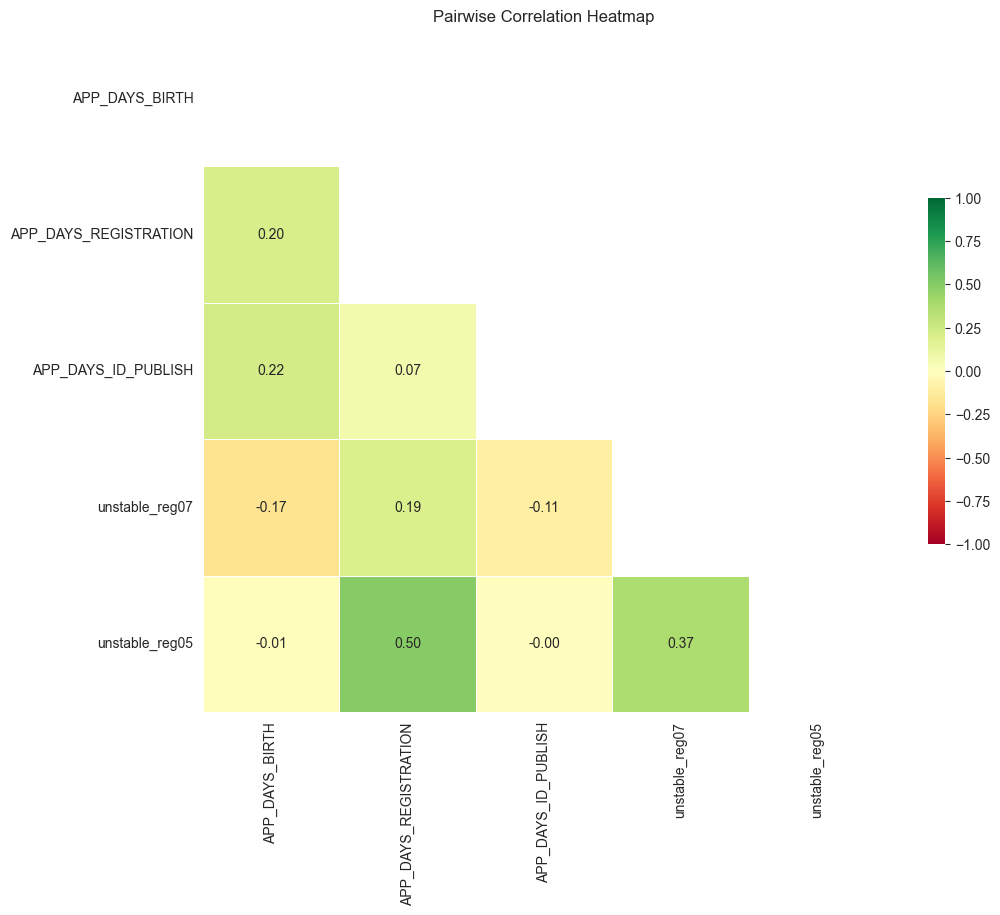

mutual_info_with_target
APP_DAYS_BIRTH                        0.003485
APP_DAYS_REGISTRATION                 0.001052
APP_DAYS_ID_PUBLISH                   0.002055
unstable_reg07                        0.060529
unstable_reg05                        0.055512

In [9]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH']]
tmp['unstable_reg07']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.7).astype(int)
tmp['unstable_reg05']=((tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH'])<0.5).astype(int)
mutual_info(tmp)

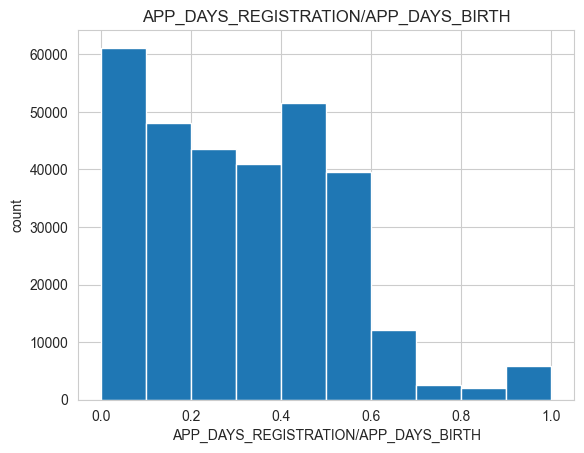

In [10]:
(tmp['APP_DAYS_REGISTRATION']/tmp['APP_DAYS_BIRTH']).hist()
plt.title('APP_DAYS_REGISTRATION/APP_DAYS_BIRTH')
plt.xlabel('APP_DAYS_REGISTRATION/APP_DAYS_BIRTH')
plt.ylabel('count')
plt.show()

### Unstable id

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


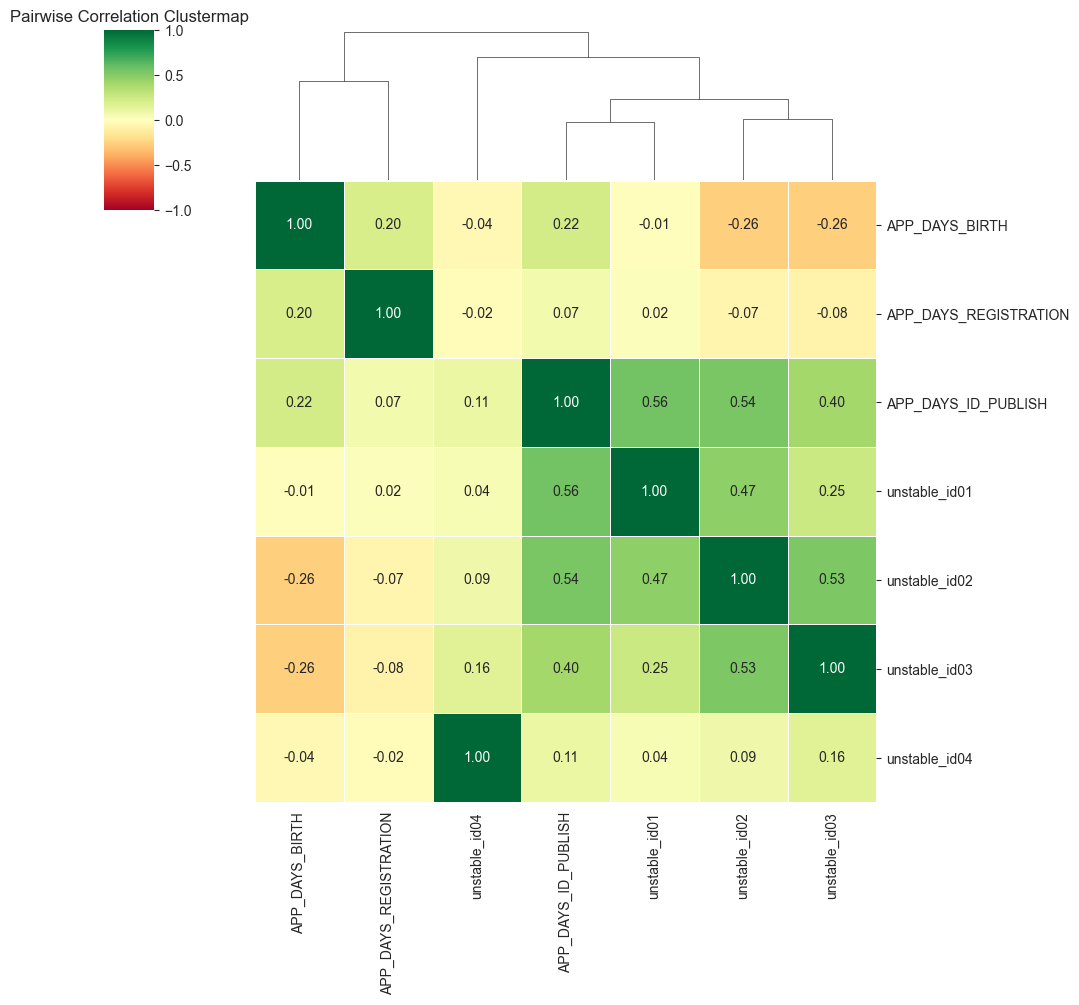

mutual_info_with_target
APP_DAYS_BIRTH                        0.003493
APP_DAYS_REGISTRATION                 0.001169
APP_DAYS_ID_PUBLISH                   0.001312
unstable_id01                         0.007249
unstable_id02                         0.047126
unstable_id03                         0.055330
unstable_id04                         0.052581

In [11]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH']]
tmp['unstable_id01']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.1).astype(int)
tmp['unstable_id02']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.2).astype(int)
tmp['unstable_id03']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.3).astype(int)
tmp['unstable_id04']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.4).astype(int)
mutual_info(tmp,clustermap=True)

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


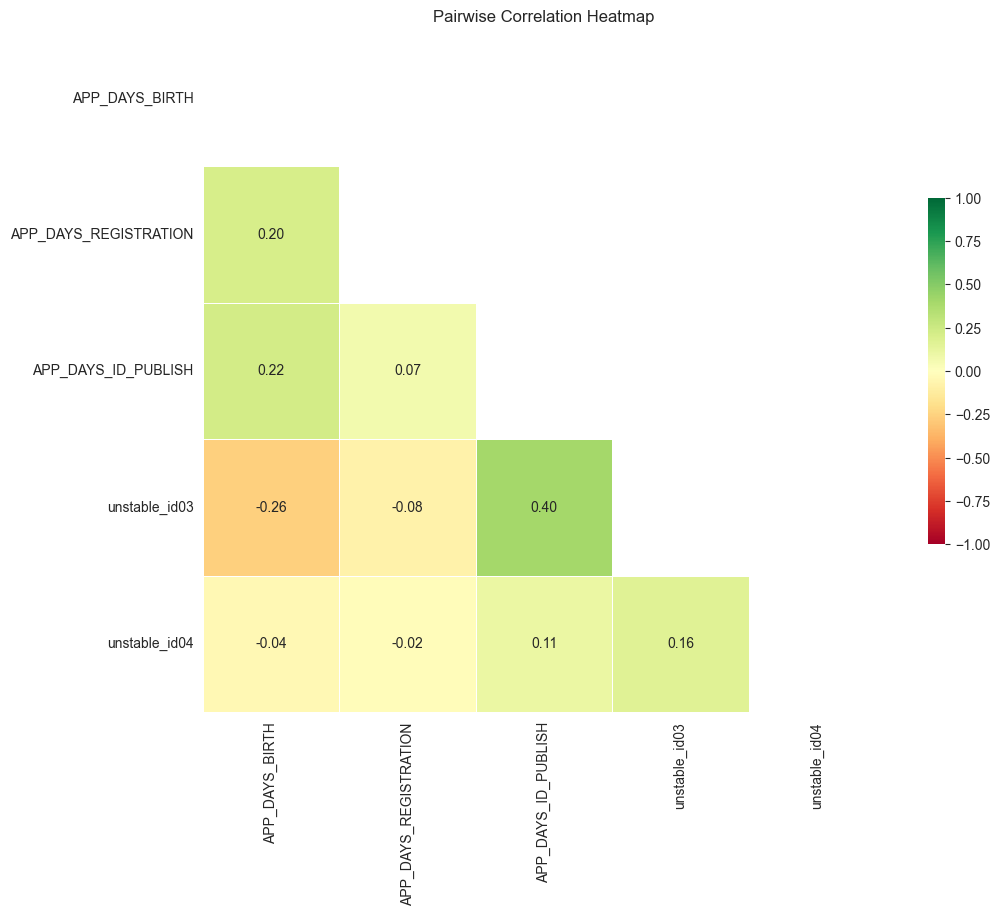

mutual_info_with_target
APP_DAYS_BIRTH                        0.003485
APP_DAYS_REGISTRATION                 0.001052
APP_DAYS_ID_PUBLISH                   0.002055
unstable_id03                         0.055040
unstable_id04                         0.053111

In [12]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH']]
# tmp['unstable_id01']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.1).astype(int)
# tmp['unstable_id02']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.2).astype(int)
tmp['unstable_id03']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.3).astype(int)
tmp['unstable_id04']=((tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH'])<0.4).astype(int)
mutual_info(tmp)

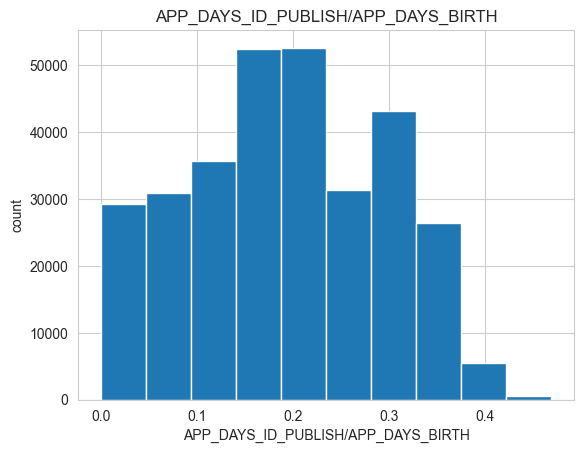

In [13]:
(tmp['APP_DAYS_ID_PUBLISH']/tmp['APP_DAYS_BIRTH']).hist()
plt.title('APP_DAYS_ID_PUBLISH/APP_DAYS_BIRTH')
plt.xlabel('APP_DAYS_ID_PUBLISH/APP_DAYS_BIRTH')
plt.ylabel('count')
plt.show()

### unstable phone change

<AxesSubplot: >

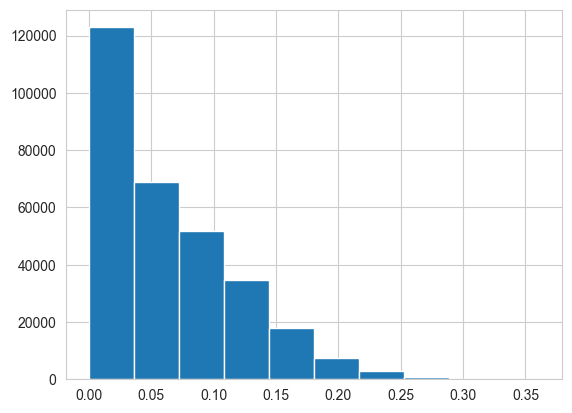

In [14]:
(cleaned_data['APP_DAYS_LAST_PHONE_CHANGE']/cleaned_data['APP_DAYS_BIRTH']).hist()

In [ ]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH','APP_DAYS_LAST_PHONE_CHANGE']]
tmp['unstable_phone005']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.05).astype(int)
tmp['unstable_phone01']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.1).astype(int)
tmp['unstable_phone015']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.15).astype(int)
tmp['unstable_phone02']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.2).astype(int)
mutual_info(tmp,clustermap=True)

In [ ]:
tmp = cleaned_data.loc[:, ['APP_DAYS_BIRTH',
                                 'APP_DAYS_REGISTRATION','APP_DAYS_ID_PUBLISH','APP_DAYS_LAST_PHONE_CHANGE']]
tmp['unstable_phone01']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.1).astype(int)
tmp['unstable_phone02']=((tmp['APP_DAYS_LAST_PHONE_CHANGE']/tmp['APP_DAYS_BIRTH'])<0.2).astype(int)
mutual_info(tmp)

## APP_AMT_CREDIT, APP_AMT_GOODS_PRICE (Kevin)

In [ ]:
((cleaned_data['APP_AMT_CREDIT'] - cleaned_data['APP_AMT_GOODS_PRICE']) / (cleaned_data['APP_AMT_GOODS_PRICE']+1)).clip(0,1).hist()
plt.title('extra_credit_ratio')
plt.xlabel('extra_credit_ratio')
plt.ylabel('count')
plt.show()

### extra_credit

In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT',
                                 'APP_AMT_GOODS_PRICE']]
tmp['extra_credit'] = (tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']).apply(lambda x: 1 if x > 0 else 0)
mutual_info(tmp,figsize=(8,9))

### extra_credit_ratio

In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT',
                                 'APP_AMT_GOODS_PRICE']]
tmp['extra_credit'] = (tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']).apply(lambda x: 1 if x > 0 else 0)
# tmp['extra_credit_ratio'] = (tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)

tmp['extra_credit_ratio005'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.05 else 0)
tmp['extra_credit_ratio01'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.1 else 0)
tmp['extra_credit_ratio015'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.15 else 0)
tmp['extra_credit_ratio02'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.2 else 0)
tmp['extra_credit_ratio03'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.3 else 0)
tmp['extra_credit_ratio04'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.4 else 0)
tmp['extra_credit_ratio05'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.5 else 0)
tmp['extra_credit_ratio06'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.6 else 0)
mutual_info(tmp,figsize=(8,9),clustermap=True)

In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT',
                                 'APP_AMT_GOODS_PRICE']]
tmp['extra_credit'] = (tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']).apply(lambda x: 1 if x > 0 else 0)
tmp['extra_credit_ratio015'] = ((tmp['APP_AMT_CREDIT'] - tmp['APP_AMT_GOODS_PRICE']) / (tmp['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.15 else 0)
mutual_info(tmp,figsize=(8,9))

## APP_NAME_INCOME_TYPE (Kevin)

### stable income type

In [ ]:
# aggregate these columns into one column where risky type (unemployed, maternity leave） is 1, high variance type (student, Businessman, Commercial associate) is 2, and stable type (working, state servant, pensioner) is 3
tmp = cleaned_data.loc[:, cleaned_data.columns[cleaned_data.columns.str.startswith('APP_NAME_INCOME_TYPE_')]]
tmp['stable_income_type']=tmp['APP_NAME_INCOME_TYPE_Working']+tmp['APP_NAME_INCOME_TYPE_Stateservant']+tmp['APP_NAME_INCOME_TYPE_Pensioner']+tmp['APP_NAME_INCOME_TYPE_Commercialassociate']
mutual_info(tmp,figsize=(8,9))

## APP_DAYS_BIRTH,APP_DAYS_ID_PUBLISH (Grace)

### Credit to Income Ratio 

In [ ]:

cleaned_data['credit_to_income_ratio'] = cleaned_data['APP_AMT_CREDIT'] / cleaned_data['APP_AMT_INCOME_TOTAL']

plt.figure(figsize=(10, 6))
cleaned_data['credit_to_income_ratio'].hist(bins=50, range=(0, cleaned_data['credit_to_income_ratio'].quantile(0.99)))
plt.title('Distribution of Credit to Income Ratio')
plt.xlabel('Credit to Income Ratio')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT', 'APP_AMT_INCOME_TOTAL']]
tmp['credit_to_income_ratio'] = tmp['APP_AMT_CREDIT'] / tmp['APP_AMT_INCOME_TOTAL']

percentiles = [50, 60, 70, 80, 90]
thresholds = [cleaned_data['credit_to_income_ratio'].quantile(p / 100.0) for p in percentiles]


for i, threshold in enumerate(thresholds):
    feature_name = f'credit_to_income_ratio_above_p{percentiles[i]}'
    tmp[feature_name] = (cleaned_data['credit_to_income_ratio'] > threshold).astype(int)

mutual_info(tmp, figsize=(8, 9), clustermap=True)


## APP_AMT_CREDIT,APP_CNT_CHILDREN (Grace)

### credit_per_child

In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT', 'APP_CNT_CHILDREN']]
tmp['CREDIT_PER_CHILD'] = tmp['APP_AMT_CREDIT'] / (tmp['APP_CNT_CHILDREN']+0.01)


#tmp['log_amt_credit'] = np.log1p(tmp['APP_AMT_CREDIT'])
#tmp['log_cnt_children'] = np.log1p(tmp['APP_CNT_CHILDREN'])
#tmp['log_credit_per_child'] = tmp['log_amt_credit'] / (tmp['log_cnt_children'] + 0.01)
#tmp['income_interaction'] = tmp['APP_AMT_CREDIT'] * np.log1p(cleaned_data['APP_AMT_INCOME_TOTAL'])
#tmp['adjusted_credit_per_child'] = tmp['income_interaction'] / (tmp['APP_CNT_CHILDREN'] + 1)

tmp = cleaned_data.loc[:, ['APP_AMT_CREDIT', 'APP_CNT_CHILDREN']]
tmp['credit_per_child'] = tmp['APP_AMT_CREDIT'] / (tmp['APP_CNT_CHILDREN'] + 0.01)

#thresholds = [816319, 29250000, 67500000, 104256000]  
thresholds = [10000, 20000, 30000, 40000, 50000]
# Create binary features for each threshold
for threshold in thresholds:
    threshold_label = str(threshold)[:-3]  
    feature_name = f'credit_per_child_above_{threshold_label}k'
    tmp[feature_name] = (tmp['credit_per_child'] > threshold).astype(int)

mutual_info(tmp,clustermap=True)

## BUREAU_AMT_CREDIT_SUM_DEBT_mean, BUREAU_AMT_CREDIT_SUM_mean (Grace)

### DEBT_CREDIT_RATIO

In [ ]:
#BUREAU_AMT_CREDIT_SUM_DEBT / BUREAU_AMT_CREDIT_SUM
tmp = cleaned_data.loc[:, ['BUREAU_AMT_CREDIT_SUM_DEBT_mean', 'BUREAU_AMT_CREDIT_SUM_mean']]
tmp['DEBT_CREDIT_RATIO'] = tmp['BUREAU_AMT_CREDIT_SUM_DEBT_mean'] / (tmp['BUREAU_AMT_CREDIT_SUM_mean']+0.01)

mutual_info(tmp)

## APP_REGION_POPULATION_RELATIVE,APP_AMT_INCOME_TOTAL (Grace)

### regional_pop_category

In [ ]:
tmp = cleaned_data.loc[:, ['APP_REGION_POPULATION_RELATIVE', 'APP_AMT_INCOME_TOTAL']]
bins = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
labels = ['1', '2', '3', '4', '5', '6', '7', '8']
tmp['regional_pop_category'] = pd.cut(tmp['APP_REGION_POPULATION_RELATIVE'], bins=bins, labels=labels).astype(int)

In [ ]:
mutual_info(tmp)

## BUREAU_AMT_CREDIT_MAX_OVERDUE_mean,APP_AMT_CREDIT (Grace)

### normalized_max_overdue

In [ ]:

tmp = cleaned_data.loc[:, ['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean','APP_AMT_CREDIT']]
tmp['OVERDUE_RATIO'] = tmp['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean']/(tmp['APP_AMT_CREDIT']+0.01)
tmp['log_max_overdue'] = np.log1p(tmp['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean'])
tmp['normalized_max_overdue'] = (tmp['log_max_overdue'] - tmp['log_max_overdue'].mean()) / tmp['log_max_overdue'].std()

mutual_info(tmp)

## INS_DAYS_ENTRY_PAYMENT_max, INS_DAYS_INSTALMENT_max (KAI)

### Max overpayment period ratio

In [ ]:
tmp = cleaned_data.loc[:, ['INS_DAYS_ENTRY_PAYMENT_max', 'INS_DAYS_INSTALMENT_max']]

tmp['max_overpayment_ratio_01'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01)
tmp['max_overpayment_ratio_02'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01) ** 2
tmp['max_overpayment_ratio_03'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01) ** 3
tmp['max_overpayment_ratio_04'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01) ** 4
tmp['max_overpayment_ratio_05'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01) ** 5

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final features added
tmp['max_overpayment_ratio_02'] = (tmp['INS_DAYS_ENTRY_PAYMENT_max'] - tmp['INS_DAYS_INSTALMENT_max']) / (tmp['INS_DAYS_INSTALMENT_max'] + 0.01) ** 2

## INS_AMT_PAYMENT_mean, INS_AMT_INSTALMENT_mean (KAI)

### Overpayment amount ratio

In [ ]:
tmp = cleaned_data.loc[:, ['INS_AMT_PAYMENT_mean', 'INS_AMT_INSTALMENT_mean']]

tmp['overpayment_amount_ratio_01'] = (tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)
tmp['overpayment_amount_ratio_02'] = ((tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)) ** 2
tmp['overpayment_amount_ratio_03'] = ((tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)) ** 3
tmp['overpayment_amount_ratio_04'] = ((tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)) ** 4
tmp['overpayment_amount_ratio_05'] = ((tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)) ** 5

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final features added
tmp['overpayment_amount_ratio_01'] = (tmp['INS_AMT_PAYMENT_mean'] - tmp['INS_AMT_INSTALMENT_mean']) / (tmp['INS_AMT_INSTALMENT_mean'] + 0.01)

## INS_AMT_PAYMENT_min, INS_AMT_INSTALMENT_min (KAI)

### Min overpayment amount ratio

In [ ]:
tmp = cleaned_data.loc[:, ['INS_AMT_PAYMENT_min', 'INS_AMT_INSTALMENT_min']]

tmp['min_overpayment_amount_ratio'] = (tmp['INS_AMT_PAYMENT_min'] - tmp['INS_AMT_INSTALMENT_min']) / (tmp['INS_AMT_INSTALMENT_min'] + 0.01)

mean = tmp['min_overpayment_amount_ratio'].mean()
median = tmp['min_overpayment_amount_ratio'].median()
pct15 = tmp['min_overpayment_amount_ratio'].quantile(0.15)
pct25 = tmp['min_overpayment_amount_ratio'].quantile(0.25)
pct35 = tmp['min_overpayment_amount_ratio'].quantile(0.35)
pct45 = tmp['min_overpayment_amount_ratio'].quantile(0.45)
pct55 = tmp['min_overpayment_amount_ratio'].quantile(0.55)
pct65 = tmp['min_overpayment_amount_ratio'].quantile(0.65)
pct75 = tmp['min_overpayment_amount_ratio'].quantile(0.75)
pct85 = tmp['min_overpayment_amount_ratio'].quantile(0.85)
pct95 = tmp['min_overpayment_amount_ratio'].quantile(0.95)

tmp['min_overpayment_amount_ratio_02'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['min_overpayment_amount_ratio_03'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > median else 0) # Median
tmp['min_overpayment_amount_ratio_04'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['min_overpayment_amount_ratio_05'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct25 else 0) # 25 pct
tmp['min_overpayment_amount_ratio_06'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct35 else 0) # 35 pct
tmp['min_overpayment_amount_ratio_07'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct
tmp['min_overpayment_amount_ratio_08'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct
tmp['min_overpayment_amount_ratio_09'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct65 else 0) # 65 pct
tmp['min_overpayment_amount_ratio_10'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct75 else 0) # 75 pct
tmp['min_overpayment_amount_ratio_11'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct85 else 0) # 85 pct
tmp['min_overpayment_amount_ratio_12'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct95 else 0) # 95 pct


mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final features added
tmp['min_overpayment_amount_ratio_04'] = tmp['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct

## INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum,INS_AMT_INSTALMENT_sum (KAI)

###  Normalised measure for discrepancy ratio relative to the size of the loan

In [ ]:
tmp = cleaned_data.loc[:,['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum', 'INS_AMT_INSTALMENT_sum']]
tmp['normalized_days_to_instalment'] = tmp['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum'] / (tmp['INS_AMT_INSTALMENT_sum'] + 0.1)
# tmp['normalized_days_to_instalment_mean'] = tmp['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum'] / (tmp['INS_AMT_INSTALMENT_mean'] + 0.1)


# Convert ratio to binary
mean = tmp['normalized_days_to_instalment'].mean()
median = tmp['normalized_days_to_instalment'].median()
pct15 = tmp['normalized_days_to_instalment'].quantile(0.15)
pct25 = tmp['normalized_days_to_instalment'].quantile(0.25)
pct35 = tmp['normalized_days_to_instalment'].quantile(0.35)
pct45 = tmp['normalized_days_to_instalment'].quantile(0.45)
pct55 = tmp['normalized_days_to_instalment'].quantile(0.55)
pct65 = tmp['normalized_days_to_instalment'].quantile(0.65)
pct75 = tmp['normalized_days_to_instalment'].quantile(0.75)
pct85 = tmp['normalized_days_to_instalment'].quantile(0.85)
pct95 = tmp['normalized_days_to_instalment'].quantile(0.95)

tmp['normalized_days_to_instalment_binary_01'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['normalized_days_to_instalment_binary_02'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > median else 0) # Median
tmp['normalized_days_to_instalment_binary_03'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['normalized_days_to_instalment_binary_04'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct25 else 0) # 25 pct
tmp['normalized_days_to_instalment_binary_05'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct35 else 0) # 35 pct
tmp['normalized_days_to_instalment_binary_06'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct
tmp['normalized_days_to_instalment_binary_07'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct
tmp['normalized_days_to_instalment_binary_08'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct65 else 0) # 65 pct
tmp['normalized_days_to_instalment_binary_09'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct75 else 0) # 75 pct
tmp['normalized_days_to_instalment_binary_10'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct85 else 0) # 85 pct
tmp['normalized_days_to_instalment_binary_11'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct95 else 0) # 95 pct

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
## Final Features added
tmp['normalized_days_to_instalment'] = tmp['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum'
                                          ] / (tmp['INS_AMT_INSTALMENT_sum'] + 0.1) # Intermediate variable, not included
tmp['normalized_days_to_instalment_binary_01'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['normalized_days_to_instalment_binary_03'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['normalized_days_to_instalment_binary_06'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct

## APP_AMT_INCOME_TOTAL, INS_AMT_PAYMENT_sum (KAI)

### Relative payment amount to the income level 

In [ ]:
tmp = cleaned_data.loc[:,['APP_AMT_INCOME_TOTAL', 'INS_AMT_PAYMENT_sum']]

# tmp['payment_relative_income'] = (np.log(tmp['INS_AMT_PAYMENT_sum'] + 0.01) / (np.log(tmp['APP_AMT_INCOME_TOTAL'] + 0.01)))
tmp['payment_relative_income'] = (np.log(tmp['INS_AMT_PAYMENT_sum'] + 0.01)) / (np.log(tmp['APP_AMT_INCOME_TOTAL'] + 0.01))

mean = tmp['payment_relative_income'].mean()
median = tmp['payment_relative_income'].median()
pct15 = tmp['payment_relative_income'].quantile(0.15)
pct25 = tmp['payment_relative_income'].quantile(0.25)
pct35 = tmp['payment_relative_income'].quantile(0.35)
pct45 = tmp['payment_relative_income'].quantile(0.45)
pct55 = tmp['payment_relative_income'].quantile(0.55)
pct65 = tmp['payment_relative_income'].quantile(0.65)
pct75 = tmp['payment_relative_income'].quantile(0.75)
pct85 = tmp['payment_relative_income'].quantile(0.85)
pct95 = tmp['payment_relative_income'].quantile(0.95)

tmp['payment_relative_income_binary_01'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['payment_relative_income_binary_02'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > median else 0) # Median
tmp['payment_relative_income_binary_03'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['payment_relative_income_binary_04'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct25 else 0) # 25 pct
tmp['payment_relative_income_binary_05'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct35 else 0) # 35 pct
tmp['payment_relative_income_binary_06'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct
tmp['payment_relative_income_binary_07'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct
tmp['payment_relative_income_binary_08'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct65 else 0) # 65 pct
tmp['payment_relative_income_binary_09'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct75 else 0) # 75 pct
tmp['payment_relative_income_binary_10'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct85 else 0) # 85 pct
tmp['payment_relative_income_binary_11'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct95 else 0) # 95 pct

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final features added
tmp['payment_relative_income'] = (np.log(tmp['INS_AMT_PAYMENT_sum'] + 0.01)) / (np.log(tmp['APP_AMT_INCOME_TOTAL'] + 0.01))
tmp['payment_relative_income_binary_03'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['payment_relative_income_binary_07'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct

## INS_AMT_INSTALMENT_sum, INS_AMT_PAYMENT_sum (KAI)

### Payment Completion Ratio

In [ ]:
tmp = cleaned_data.loc[:,['INS_AMT_INSTALMENT_sum', 'INS_AMT_PAYMENT_sum']]

tmp['payment_completion_ratio'] = (tmp['INS_AMT_PAYMENT_sum'] + 0.01) / (tmp['INS_AMT_INSTALMENT_sum'] + 0.01)

mean = tmp['payment_completion_ratio'].mean()
median = tmp['payment_completion_ratio'].median()
pct15 = tmp['payment_completion_ratio'].quantile(0.15)
pct25 = tmp['payment_completion_ratio'].quantile(0.25)
pct35 = tmp['payment_completion_ratio'].quantile(0.35)
pct45 = tmp['payment_completion_ratio'].quantile(0.45)
pct55 = tmp['payment_completion_ratio'].quantile(0.55)
pct65 = tmp['payment_completion_ratio'].quantile(0.65)
pct75 = tmp['payment_completion_ratio'].quantile(0.75)
pct85 = tmp['payment_completion_ratio'].quantile(0.85)
pct95 = tmp['payment_completion_ratio'].quantile(0.95)

tmp['payment_completion_ratio_binary_01'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['payment_completion_ratio_binary_02'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > median else 0) # Median
tmp['payment_completion_ratio_binary_03'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['payment_completion_ratio_binary_04'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct25 else 0) # 25 pct
tmp['payment_completion_ratio_binary_05'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct35 else 0) # 35 pct
tmp['payment_completion_ratio_binary_06'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct
tmp['payment_completion_ratio_binary_07'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct
tmp['payment_completion_ratio_binary_08'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct65 else 0) # 65 pct
tmp['payment_completion_ratio_binary_09'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct75 else 0) # 75 pct
tmp['payment_completion_ratio_binary_10'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct85 else 0) # 85 pct
tmp['payment_completion_ratio_binary_11'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct95 else 0) # 95 pct

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final Features Added
tmp['payment_completion_ratio_binary_03'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct

## APP_AMT_ANNUITY,APP_AMT_INCOME_TOTAL (KAI)

### Annuity as a percentage of income

In [ ]:
tmp = cleaned_data.loc[:,['APP_AMT_ANNUITY', 'APP_AMT_INCOME_TOTAL']]

tmp['annuity_relative_income'] = np.log(tmp['APP_AMT_ANNUITY'] + 0.01) / np.log(tmp['APP_AMT_INCOME_TOTAL'] + 0.01)
mean = tmp['annuity_relative_income'].mean()
median = tmp['annuity_relative_income'].median()
pct15 = tmp['annuity_relative_income'].quantile(0.15)
pct25 = tmp['annuity_relative_income'].quantile(0.25)
pct35 = tmp['annuity_relative_income'].quantile(0.35)
pct45 = tmp['annuity_relative_income'].quantile(0.45)
pct55 = tmp['annuity_relative_income'].quantile(0.55)
pct65 = tmp['annuity_relative_income'].quantile(0.65)
pct75 = tmp['annuity_relative_income'].quantile(0.75)
pct85 = tmp['annuity_relative_income'].quantile(0.85)
pct95 = tmp['annuity_relative_income'].quantile(0.95)

tmp['annuity_relative_income_binary_01'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > mean else 0) # Mean
tmp['annuity_relative_income_binary_02'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > median else 0) # Median
tmp['annuity_relative_income_binary_03'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
tmp['annuity_relative_income_binary_04'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct25 else 0) # 25 pct
tmp['annuity_relative_income_binary_05'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct35 else 0) # 35 pct
tmp['annuity_relative_income_binary_06'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct
tmp['annuity_relative_income_binary_07'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct
tmp['annuity_relative_income_binary_08'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct65 else 0) # 65 pct
tmp['annuity_relative_income_binary_09'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct75 else 0) # 75 pct
tmp['annuity_relative_income_binary_10'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct85 else 0) # 85 pct
tmp['annuity_relative_income_binary_11'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct95 else 0) # 95 pct

mutual_info(tmp, figsize = (9,9), clustermap = True)

In [ ]:
# Final Features added
tmp['annuity_relative_income_binary_03'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct

## PREV_APP_CNT_PAYMENT_sum, PREV_APP_AMT_CREDIT_sum (Evelyn&Nicola)

### avg_credit_approval_per_month

In [ ]:
tmp = cleaned_data.loc[:, ['PREV_APP_CNT_PAYMENT_sum', 'PREV_APP_AMT_CREDIT_sum']]
avg_cnt_payment = np.mean(cleaned_data.PREV_APP_CNT_PAYMENT_sum)
std_cnt_payment = np.std(cleaned_data.PREV_APP_CNT_PAYMENT_sum)
tmp['avg_credit_approval_per_month'] = cleaned_data.PREV_APP_AMT_CREDIT_sum / ((cleaned_data.PREV_APP_CNT_PAYMENT_sum - avg_cnt_payment)/std_cnt_payment)

mutual_info(tmp)

## APP_AMT_GOODS_PRICE, APP_AMT_CREDIT (Evelyn&Nicola)

### Pct_good_p_in_credit_curr

In [ ]:
tmp = cleaned_data.loc[:, ['APP_AMT_GOODS_PRICE', 'APP_AMT_CREDIT']]
tmp['Pct_good_p_in_credit_curr'] = cleaned_data.APP_AMT_GOODS_PRICE / cleaned_data.APP_AMT_CREDIT
mutual_info(tmp)

## PREV_APP_AMT_APPLICATION_sum, PREV_APP_AMT_CREDIT_sum (Evelyn&Nicola)

### approval_imbalance

In [ ]:
tmp = cleaned_data.loc[:, ['PREV_APP_AMT_APPLICATION_sum', 'PREV_APP_AMT_CREDIT_sum']]
cleaned_data['prev_app_amt_app_sum_standard'] = (cleaned_data.PREV_APP_AMT_APPLICATION_sum - np.mean(cleaned_data.PREV_APP_AMT_APPLICATION_sum))/np.std(cleaned_data.PREV_APP_AMT_APPLICATION_sum)
cleaned_data['prev_app_amt_credit_sum_standard'] = (cleaned_data.PREV_APP_AMT_CREDIT_sum - np.mean(cleaned_data.PREV_APP_AMT_CREDIT_sum))/np.std(cleaned_data.PREV_APP_AMT_CREDIT_sum)
# take standardization to avoid div 0
tmp['approval_imbalance'] = (cleaned_data.prev_app_amt_app_sum_standard - cleaned_data.prev_app_amt_credit_sum_standard) / (cleaned_data.prev_app_amt_app_sum_standard + cleaned_data.prev_app_amt_credit_sum_standard)
cleaned_data.drop(['prev_app_amt_app_sum_standard', 'prev_app_amt_credit_sum_standard'], axis='columns')
mutual_info(tmp)

## APP_FLAG_DOCUMENT (Evelyn&Nicola)

### document_complete

In [ ]:
tmp = cleaned_data.loc[:, ['APP_FLAG_DOCUMENT_2', 'APP_FLAG_DOCUMENT_3', 'APP_FLAG_DOCUMENT_4',
                          'APP_FLAG_DOCUMENT_5', 'APP_FLAG_DOCUMENT_6', 'APP_FLAG_DOCUMENT_7',
                          'APP_FLAG_DOCUMENT_8', 'APP_FLAG_DOCUMENT_9', 'APP_FLAG_DOCUMENT_10',
                          'APP_FLAG_DOCUMENT_11', 'APP_FLAG_DOCUMENT_12', 'APP_FLAG_DOCUMENT_13',
                          'APP_FLAG_DOCUMENT_14', 'APP_FLAG_DOCUMENT_15', 'APP_FLAG_DOCUMENT_16',
                          'APP_FLAG_DOCUMENT_17', 'APP_FLAG_DOCUMENT_18', 'APP_FLAG_DOCUMENT_19',
                          'APP_FLAG_DOCUMENT_20']]
tmp['document_complete'] = tmp.sum(axis=1)
mutual_info(tmp)

## AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT,CC_AMT_INST_MIN_REGULARITY_sum,AMT_PAYMENT_CURRENT (Evelyn&Nicola)

### pct_min_missed_payment

In [ ]:
# credit card balance
def pct_min_missed_payment(min_pay, total_pay):
    M = min_pay.tolist()
    T = total_pay.tolist()
    L = len(M)
    count = 0
    # find the count of transactions when payment made is less than min payment
    for i in range(L):
        if T[i]<M[i]:
            count+=1
    return (100*count)/L

grp = credit_card_balance.groupby('SK_ID_CURR').apply(lambda x: pct_min_missed_payment(x.AMT_INST_MIN_REGULARITY,
                                                                                      x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MIN_MISSED_PAYMENTS'}).set_index('SK_ID_CURR').reindex(application['SK_ID_CURR']).fillna(-1)

CCB=cleaned_data.merge(grp, on='SK_ID_CURR', how='left')
tmp = CCB.loc[:, ['CC_AMT_INST_MIN_REGULARITY_sum', 'AMT_PAYMENT_CURRENT']]
tmp['PERCENTAGE_MIN_MISSED_PAYMENTS']=CCB['PERCENTAGE_MIN_MISSED_PAYMENTS']
mutual_info(tmp)

# Gather all potential features

In [ ]:
potential_features = pd.DataFrame(index=cleaned_data.index)
# kevin
potential_features['source_1_3_zero']=cleaned_data['APP_EXT_SOURCE_1'].apply(lambda x: 1 if x==0 else 0)/cleaned_data['APP_EXT_SOURCE_1'].value_counts()[0]+cleaned_data['APP_EXT_SOURCE_3'].apply(lambda x: 1 if x==0 else 0)/cleaned_data['APP_EXT_SOURCE_3'].value_counts()[0]

potential_features['unstable_reg07']=((cleaned_data['APP_DAYS_REGISTRATION']/cleaned_data['APP_DAYS_BIRTH'])<0.7).astype(int)

potential_features['unstable_reg05']=((cleaned_data['APP_DAYS_REGISTRATION']/cleaned_data['APP_DAYS_BIRTH'])<0.5).astype(int)

potential_features['unstable_id03']=((cleaned_data['APP_DAYS_ID_PUBLISH']/cleaned_data['APP_DAYS_BIRTH'])<0.3).astype(int)

potential_features['unstable_id04']=((cleaned_data['APP_DAYS_ID_PUBLISH']/cleaned_data['APP_DAYS_BIRTH'])<0.4).astype(int)

potential_features['unstable_phone01']=((cleaned_data['APP_DAYS_LAST_PHONE_CHANGE']/cleaned_data['APP_DAYS_BIRTH'])<0.1).astype(int)

potential_features['unstable_phone02']=((cleaned_data['APP_DAYS_LAST_PHONE_CHANGE']/cleaned_data['APP_DAYS_BIRTH'])<0.2).astype(int)

potential_features['extra_credit'] = (cleaned_data['APP_AMT_CREDIT'] - cleaned_data['APP_AMT_GOODS_PRICE']).apply(lambda x: 1 if x > 0 else 0)

potential_features['extra_credit_ratio015'] = ((cleaned_data['APP_AMT_CREDIT'] - cleaned_data['APP_AMT_GOODS_PRICE']) / (cleaned_data['APP_AMT_GOODS_PRICE']+1)).clip(0,1).apply(lambda x: 1 if x > 0.15 else 0)

potential_features['stable_income_type']=cleaned_data['APP_NAME_INCOME_TYPE_Working']+cleaned_data['APP_NAME_INCOME_TYPE_Stateservant']+cleaned_data['APP_NAME_INCOME_TYPE_Pensioner']+cleaned_data['APP_NAME_INCOME_TYPE_Commercialassociate']

# Grace
potential_features['credit_to_income_ratio_above_p50']=(cleaned_data['APP_AMT_CREDIT'] / cleaned_data['APP_AMT_INCOME_TOTAL']).apply(lambda x: 1 if x>cleaned_data['credit_to_income_ratio'].quantile(0.5) else 0) 

potential_features['credit_per_child_above_10k']=((cleaned_data['APP_AMT_CREDIT'] / (cleaned_data['APP_CNT_CHILDREN']+0.01))>10000).astype(int)

potential_features['credit_per_child_above_50k']=((cleaned_data['APP_AMT_CREDIT'] / (cleaned_data['APP_CNT_CHILDREN']+0.01))>50000).astype(int)

potential_features['DEBT_CREDIT_RATIO'] = cleaned_data['BUREAU_AMT_CREDIT_SUM_DEBT_mean'] / (cleaned_data['BUREAU_AMT_CREDIT_SUM_mean']+0.01)

bins = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
labels = ['1', '2', '3', '4', '5', '6', '7', '8']
potential_features['regional_pop_category'] = pd.cut(cleaned_data['APP_REGION_POPULATION_RELATIVE'], bins=bins, labels=labels).astype(int)

potential_features['normalized_max_overdue']= (np.log1p(cleaned_data['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean']) - np.log1p(cleaned_data['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean']).mean()) / np.log1p(cleaned_data['BUREAU_AMT_CREDIT_MAX_OVERDUE_mean']).std()

# Kai
potential_features['max_overpayment_ratio_02'] = (cleaned_data['INS_DAYS_ENTRY_PAYMENT_max'] - cleaned_data['INS_DAYS_INSTALMENT_max']) / (cleaned_data['INS_DAYS_INSTALMENT_max'] + 0.01) ** 2

potential_features['overpayment_amount_ratio_01'] = (cleaned_data['INS_AMT_PAYMENT_mean'] - cleaned_data['INS_AMT_INSTALMENT_mean']) / (cleaned_data['INS_AMT_INSTALMENT_mean'] + 0.01)

pct15 = cleaned_data['min_overpayment_amount_ratio'].quantile(0.15)
potential_features['min_overpayment_amount_ratio_04'] = cleaned_data['min_overpayment_amount_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct

potential_features['normalized_days_to_instalment'] = cleaned_data['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum'
                                          ] / (cleaned_data['INS_AMT_INSTALMENT_sum'] + 0.1) # Intermediate variable, not included

tmp = pd.DataFrame()
tmp['normalized_days_to_instalment'] = cleaned_data['INS_DAYS_INSTALMENT_DAYS_ENTRY_PAYMENT_diff_sum'
                                          ] / (cleaned_data['INS_AMT_INSTALMENT_sum'] + 0.1)
tmp['min_overpayment_amount_ratio'] = (cleaned_data['INS_AMT_PAYMENT_min'] - cleaned_data['INS_AMT_INSTALMENT_min']) / (cleaned_data['INS_AMT_INSTALMENT_min'] + 0.01)
tmp_mean = tmp['min_overpayment_amount_ratio'].mean()
pct15 = tmp['min_overpayment_amount_ratio'].quantile(0.15)
pct45 = tmp['min_overpayment_amount_ratio'].quantile(0.45)
potential_features['normalized_days_to_instalment_binary_01'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > tmp_mean else 0) # Mean
potential_features['normalized_days_to_instalment_binary_03'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
potential_features['normalized_days_to_instalment_binary_06'] = tmp['normalized_days_to_instalment'].apply(lambda x: 1 if x > pct45 else 0) # 45 pct

tmp['payment_relative_income'] = (np.log(cleaned_data['INS_AMT_PAYMENT_sum'] + 0.01)) / (np.log(cleaned_data['APP_AMT_INCOME_TOTAL'] + 0.01))
pct15 = tmp['payment_relative_income'].quantile(0.15)
pct55 = tmp['payment_relative_income'].quantile(0.55)
potential_features['payment_relative_income_binary_03'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
potential_features['payment_relative_income_binary_07'] = tmp['payment_relative_income'].apply(lambda x: 1 if x > pct55 else 0) # 55 pct

tmp['payment_completion_ratio'] = (cleaned_data['INS_AMT_PAYMENT_sum'] + 0.01) / (cleaned_data['INS_AMT_INSTALMENT_sum'] + 0.01)
pct15 = tmp['payment_completion_ratio'].quantile(0.15)
tmp['payment_completion_ratio_binary_03'] = tmp['payment_completion_ratio'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct

tmp['annuity_relative_income'] = np.log(cleaned_data['APP_AMT_ANNUITY'] + 0.01) / np.log(cleaned_data['APP_AMT_INCOME_TOTAL'] + 0.01)
pct15 = tmp['annuity_relative_income'].quantile(0.15)
tmp['annuity_relative_income_binary_03'] = tmp['annuity_relative_income'].apply(lambda x: 1 if x > pct15 else 0) # 15 pct
del tmp
import gc
gc.collect()
# Evelyn & Nicola
avg_cnt_payment = np.mean(cleaned_data.PREV_APP_CNT_PAYMENT_sum)
std_cnt_payment = np.std(cleaned_data.PREV_APP_CNT_PAYMENT_sum)
potential_features['avg_credit_approval_per_month'] = cleaned_data.PREV_APP_AMT_CREDIT_sum / ((cleaned_data.PREV_APP_CNT_PAYMENT_sum - avg_cnt_payment)/std_cnt_payment)

potential_features['Pct_good_p_in_credit_curr'] = cleaned_data.APP_AMT_GOODS_PRICE / cleaned_data.APP_AMT_CREDIT
tmp=pd.DataFrame()
tmp['prev_app_amt_app_sum_standard'] = (cleaned_data.PREV_APP_AMT_APPLICATION_sum - np.mean(cleaned_data.PREV_APP_AMT_APPLICATION_sum))/np.std(cleaned_data.PREV_APP_AMT_APPLICATION_sum)
tmp['prev_app_amt_credit_sum_standard'] = (cleaned_data.PREV_APP_AMT_CREDIT_sum - np.mean(cleaned_data.PREV_APP_AMT_CREDIT_sum))/np.std(cleaned_data.PREV_APP_AMT_CREDIT_sum)
# take standardization to avoid div 0
tmp['approval_imbalance'] = (tmp.prev_app_amt_app_sum_standard - tmp.prev_app_amt_credit_sum_standard) / (tmp.prev_app_amt_app_sum_standard + tmp.prev_app_amt_credit_sum_standard)

potential_features['document_complete'] = cleaned_data.loc[:, ['APP_FLAG_DOCUMENT_2', 'APP_FLAG_DOCUMENT_3', 'APP_FLAG_DOCUMENT_4',
                          'APP_FLAG_DOCUMENT_5', 'APP_FLAG_DOCUMENT_6', 'APP_FLAG_DOCUMENT_7',
                          'APP_FLAG_DOCUMENT_8', 'APP_FLAG_DOCUMENT_9', 'APP_FLAG_DOCUMENT_10',
                          'APP_FLAG_DOCUMENT_11', 'APP_FLAG_DOCUMENT_12', 'APP_FLAG_DOCUMENT_13',
                          'APP_FLAG_DOCUMENT_14', 'APP_FLAG_DOCUMENT_15', 'APP_FLAG_DOCUMENT_16',
                          'APP_FLAG_DOCUMENT_17', 'APP_FLAG_DOCUMENT_18', 'APP_FLAG_DOCUMENT_19',
                          'APP_FLAG_DOCUMENT_20']].sum(axis=1)
del tmp
gc.collect()
# credit card balance
credit_card_balance=pd.read_csv('./src/credit_card_balance.csv')
application=pd.read_csv('./src/application_train.csv')
def pct_min_missed_payment(min_pay, total_pay):
    M = min_pay.tolist()
    T = total_pay.tolist()
    L = len(M)
    count = 0
    # find the count of transactions when payment made is less than min payment
    for i in range(L):
        if T[i]<M[i]:
            count+=1
    return (100*count)/L

grp = credit_card_balance.groupby('SK_ID_CURR').apply(lambda x: pct_min_missed_payment(x.AMT_INST_MIN_REGULARITY,
                                                                                      x.AMT_PAYMENT_CURRENT)).reset_index().rename(index = str, columns = { 0 : 'PERCENTAGE_MIN_MISSED_PAYMENTS'}).set_index('SK_ID_CURR').reindex(application['SK_ID_CURR']).fillna(-1)

potential_features['PERCENTAGE_MIN_MISSED_PAYMENTS']=grp['PERCENTAGE_MIN_MISSED_PAYMENTS']

In [ ]:
potential_features.to_csv('./src/potential_features.csv')

D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
D:\conda\envs\MMF1914_IT\lib\site-packages\scipy\stats\_stats_py.py:5279: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)


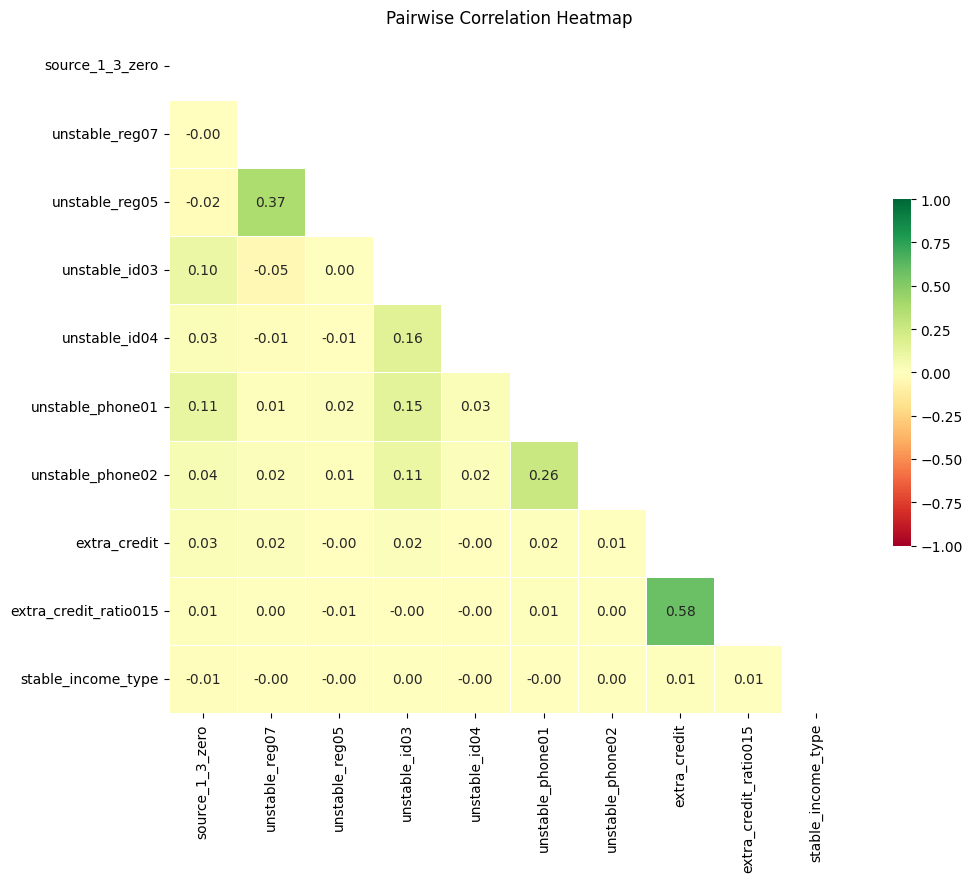

mutual_info_with_target
stable_income_type                    0.073857
unstable_reg07                        0.060687
unstable_phone01                      0.056614
unstable_id03                         0.055484
unstable_reg05                        0.055236
extra_credit                          0.054299
unstable_id04                         0.053382
unstable_phone02                      0.048800
extra_credit_ratio015                 0.026427
source_1_3_zero                       0.011891

In [236]:
mutual_info(potential_features,sort=True)

# ML

## Verify lightgbm can run

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42, stratify=cleaned_data['TARGET'])

In [26]:
# load data using lightgbm
train_data = lgb.Dataset(train.drop('TARGET', axis=1), label=train['TARGET'])

In [27]:
# lightgbm parameters
params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc', 'n_jobs': 1}# njobs = 1 to avoid multithreading, keep reproducability

In [28]:
# lightgbm training
gbm = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 75047
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 676
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

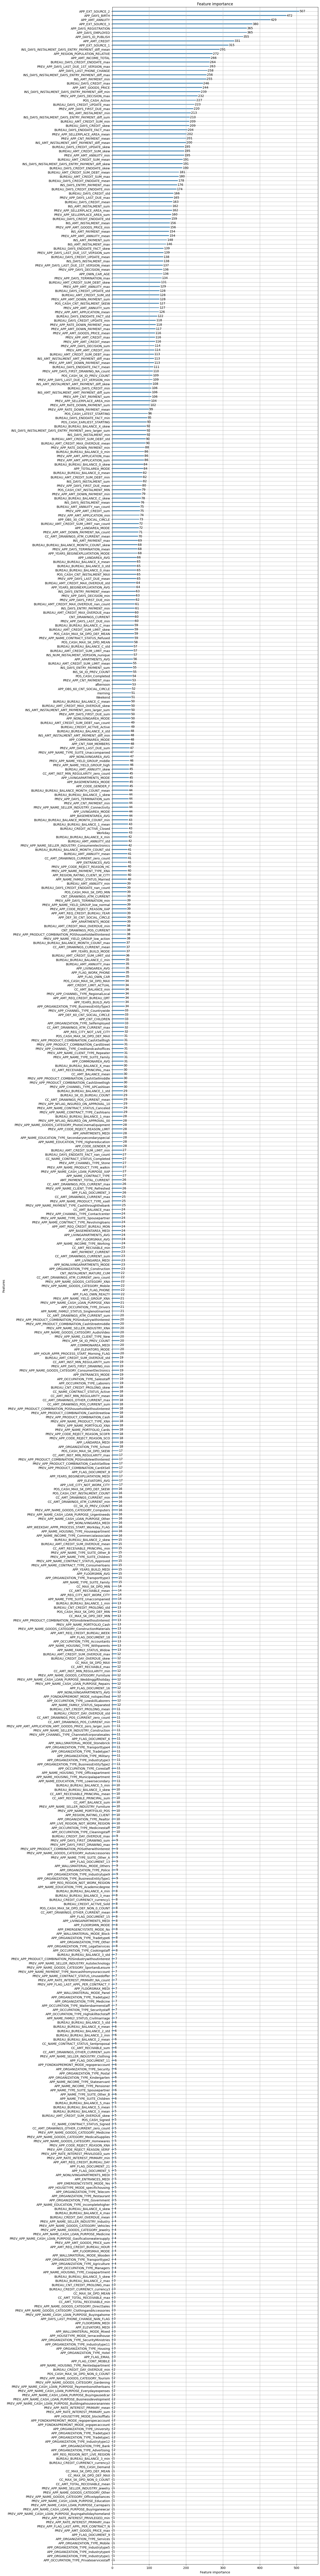

In [29]:
# plot feature importance
lgb.plot_importance(gbm, figsize=(12, 150))

In [205]:
# get insample performance
from sklearn.metrics import roc_auc_score

print('IN-sample', roc_auc_score(train['TARGET'], gbm.predict(train.drop('TARGET', axis=1))))

IN-sample 0.9494252053049559


In [206]:
# get outsample performance
print('OOS', roc_auc_score(test['TARGET'], gbm.predict(test.drop('TARGET', axis=1))))

OOS 0.7696663477979875


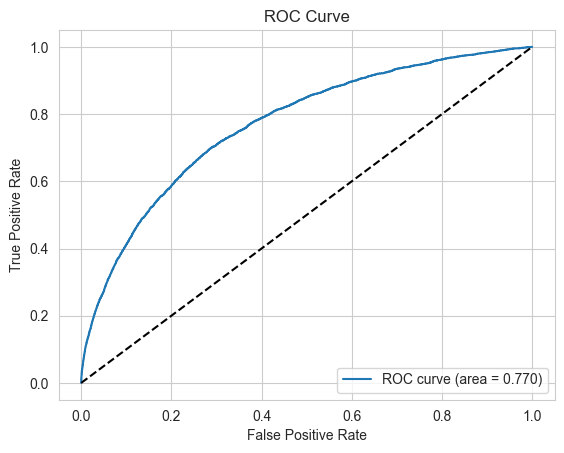

In [207]:
# plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test['TARGET'], gbm.predict(test.drop('TARGET', axis=1)))
plt.plot(fpr, tpr,
         label='ROC curve (area = %0.3f)' % roc_auc_score(test['TARGET'], gbm.predict(test.drop('TARGET', axis=1))))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Using Pycaret to do a run through all different models

In [1]:
from pycaret.classification import *

In [7]:
s = setup(train, target='TARGET', session_id=123, log_experiment=True, experiment_name='home_credit')

In [9]:
best = compare_models(n_select=5, sort='AUC')

Initiated  . . . . . . . . . . . . . . . . . .              02:21:56
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/73 [00:00<?, ?it/s]

In [10]:

with open('./src/pycaret_best_model.pkl', 'wb') as f:
    pickle.dump(best, f)

In [11]:
pull()

Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.9195  0.7682  0.0155  0.5453   
lightgbm  Light Gradient Boosting Machine    0.9195  0.7760  0.0351  0.5251   
catboost              CatBoost Classifier    0.9194  0.7815  0.0419  0.5089   
ridge                    Ridge Classifier    0.9193  0.0000  0.0013  0.4833   
rf               Random Forest Classifier    0.9193  0.7095  0.0012  0.7333   
et                 Extra Trees Classifier    0.9193  0.7069  0.0011  0.6417   
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000   
ada                  Ada Boost Classifier    0.9191  0.7565  0.0185  0.4698   
lr                    Logistic Regression    0.9189  0.6698  0.0016  0.2156   
xgboost         Extreme Gradient Boosting    0.9180  0.7642  0.0580  0.4394   
knn                K Neighbors Classifier    0.9139  0.5457  0.0159  0.1617   
svm                   SVM - Linear Kernel    0.8571  0.0000  0.1036  0.1407   
dt               Decision Tree Classifier    0.8527  0.5386  0.1639  0.1424   
lda          Linear Discriminant Analysis    0.8258  0.6840  0.0455  0.3703   
nb                            Naive Bayes    0.1987  0.6124  0.9176  0.0853   
qda       Quadratic Discriminant Analysis    0.1589  0.3037  0.5856  0.0490   

              F1   Kappa     MCC  TT (Sec)  
gbc       0.0301  0.0257  0.0816   246.506  
lightgbm  0.0658  0.0562  0.1200    21.640  
catboost  0.0774  0.0660  0.1285   123.755  
ridge     0.0026  0.0021  0.0209    23.875  
rf        0.0024  0.0022  0.0272    71.987  
et        0.0022  0.0019  0.0236    49.962  
dummy     0.0000  0.0000  0.0000     9.322  
ada       0.0356  0.0296  0.0805    61.716  
lr        0.0031  0.0020  0.0118   120.044  
xgboost   0.1023  0.0851  0.1365    26.751  
knn       0.0289  0.0147  0.0265    81.983  
svm       0.0801  0.0306  0.0369    19.283  
dt        0.1523  0.0722  0.0724    37.340  
lda       0.0810  0.0663  0.1093    38.724  
nb        0.1560  0.0098  0.0430    10.429  
qda       0.0904  0.0012  0.0104    23.954

In [10]:
read_in_best = pickle.load(open('./src/pycaret_best_model.pkl', 'rb'))

In [15]:
read_in_best[4]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [16]:
tuned_model_list = []
model_name_list = ['gbc', 'lightgbm', 'catboost', 'ridge', 'rf']
for model, model_name in zip(read_in_best, model_name_list):
    print(model)
    tuned_model = tune_model(model)
    tuned_model_list.append(tuned_model)
    pull()
    print('done')
    with open(f'./src/pycaret_tuned_model_{model_name}.pkl', 'wb') as f:
        pickle.dump(tuned_model, f)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Initiated  . . . . . . . . . . . . . . . . . .              09:26:33
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
with open('./src/pycaret_tuned_model_list.pkl', 'wb') as f:
    pickle.dump(tuned_model_list, f)

## try tabnet

In [17]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [18]:
from sklearn.model_selection import KFold

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tabnet_params = dict(n_steps=1,
                     optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=1e-2, weight_decay=5e-4),
                     scheduler_params={"step_size": 1,  # how to use learning rate scheduler
                                       "gamma": 0.7},
                     scheduler_fn=torch.optim.lr_scheduler.StepLR,
                     mask_type='entmax',
                     verbose=5)

for fold, (train_idx, validate_idx) in enumerate(kf.split(train)):
    print(f'fold {fold}')
    X_train, y_train = train.drop('TARGET', axis=1).iloc[train_idx], train['TARGET'].iloc[train_idx]
    X_valid, y_valid = train.drop('TARGET', axis=1).iloc[validate_idx], train['TARGET'].iloc[validate_idx]
    clf = TabNetClassifier(**tabnet_params)
    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=100, patience=5,
        batch_size=1024 * 10, virtual_batch_size=128 * 10,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    clf.save_model(f'./src/tabnet_fold_{fold}.pth')
    
    

fold 0
epoch 0  | loss: 0.6922  | train_auc: 0.57396 | valid_auc: 0.57325 |  0:00:31s
epoch 5  | loss: 0.551   | train_auc: 0.75476 | valid_auc: 0.73584 |  0:02:55s
epoch 10 | loss: 0.52752 | train_auc: 0.78293 | valid_auc: 0.74312 |  0:05:19s
epoch 15 | loss: 0.52382 | train_auc: 0.79654 | valid_auc: 0.74504 |  0:07:44s
epoch 20 | loss: 0.52328 | train_auc: 0.80414 | valid_auc: 0.74446 |  0:10:08s

Early stopping occurred at epoch 21 with best_epoch = 16 and best_valid_auc = 0.74528
Successfully saved model at ./src/tabnet_fold_0.pth.zip
fold 1
epoch 0  | loss: 0.69069 | train_auc: 0.6081  | valid_auc: 0.6139  |  0:00:29s
epoch 5  | loss: 0.55382 | train_auc: 0.75782 | valid_auc: 0.73919 |  0:02:54s
epoch 10 | loss: 0.52655 | train_auc: 0.78271 | valid_auc: 0.74821 |  0:05:16s
epoch 15 | loss: 0.5217  | train_auc: 0.79535 | valid_auc: 0.75047 |  0:07:39s
epoch 20 | loss: 0.52065 | train_auc: 0.80367 | valid_auc: 0.75027 |  0:10:06s

Early stopping occurred at epoch 24 with best_epoch 

# Onboarding profit analysis
preprocess for the previous application data: 
1. delete the ones that have XNA or consumer loan type of loan
2. figuring out which have defaulted based on installment data
3. calculate the default loss (some customers does have payback before default)
## for every application non-default:
distinguish between cash loan and revolving loan
find the closest resemble from previous application that did not default
calculate the PV of profit assuming the risk free interest rate is 5%
## for every application default:


In [140]:
previous_application = pd.read_csv('./src/previous_application.csv')
application = pd.read_csv('./src/application_train.csv')

In [141]:
previous_application['NAME_CONTRACT_TYPE'].value_counts() # we drop xna and change consumer loan to cash loan

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [143]:
application['NAME_CONTRACT_TYPE'].value_counts() # the application we care about only contains cash loan and revolving loan

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [144]:
previous_application = previous_application[(previous_application['NAME_CONTRACT_TYPE']!='XNA')&(previous_application['NAME_CONTRACT_TYPE']!='Consumer loans')]

In [145]:
# get previd for cash and revolving loan seperately
cash_loan_prev_id = previous_application[previous_application['NAME_CONTRACT_TYPE']=='Cash loans']['SK_ID_PREV'].unique()
revolving_loan_prev_id = previous_application[previous_application['NAME_CONTRACT_TYPE']=='Revolving loans']['SK_ID_PREV'].unique()

process installment data

In [266]:
installments_payments = pd.read_csv('./src/installments_payments.csv')

In [267]:
installments_payments = installments_payments.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER']).agg({'DAYS_INSTALMENT':'first','DAYS_ENTRY_PAYMENT':'last','AMT_INSTALMENT':'first','AMT_PAYMENT':'sum'}).reset_index()

In [268]:
installments_payments['AMOUNT_NOT_PAID'] = (installments_payments['AMT_INSTALMENT']-installments_payments['AMT_PAYMENT']).apply(lambda x: 0 if x < 1 else x)# only when insurancce is at play, the amount paid can be larger than the amount due. less than 1 because float precision

In [269]:
installments_payments['DAYS_DIFF'] = (installments_payments['DAYS_ENTRY_PAYMENT']-installments_payments['DAYS_INSTALMENT']).apply(lambda x: 0 if x<0 else x)# there is no benefit for early repayment so we set it to 0

seperate cash and revolving loan

In [270]:
cash_installment=installments_payments[installments_payments['SK_ID_PREV'].isin(cash_loan_prev_id)]
revolving_loan_installment=installments_payments[installments_payments['SK_ID_PREV'].isin(revolving_loan_prev_id)]

In [271]:
# we havent finish this month 
cash_installment = cash_installment[cash_installment['DAYS_INSTALMENT']+30<0]
revolving_loan_installment = revolving_loan_installment[revolving_loan_installment['DAYS_INSTALMENT']+30<0]

In [272]:
cash_installment['DAYS_DIFF']=cash_installment.apply(lambda x: x['DAYS_DIFF'] if x['AMOUNT_NOT_PAID']< 1 else abs(x['DAYS_INSTALMENT']),axis=1)# if not payed in full, we count as delayed payment until now.

In [273]:
def cal_amount_delayed_payment(x):
    if x['DAYS_DIFF']>0:
        if x['AMOUNT_NOT_PAID']<1:
            return x['AMT_INSTALMENT']# client paid in full but delayed
    return 0# 2 possible situation: 1. day diff>0 and amount not paid>0.1, accounted by the amount not paid. 2. day diff<=0, no delayed payment

In [274]:
cash_installment['AMOUNT_DELAYED_PAYMENT']=cash_installment.apply(cal_amount_delayed_payment,axis=1)

In [275]:
# defaulted_cash_installment = cash_installment[(cash_installment['DAYS_ENTRY_PAYMENT'].isnull())|(cash_installment['DAYS_DIFF']>=17)]# 15 days grace period

In [276]:
cash_installment[cash_installment['DAYS_ENTRY_PAYMENT'].isnull()]

SK_ID_PREV  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
159151       1016839                     29            -76.0   
159152       1016839                     30            -46.0   
271464       1032257                      3           -107.0   
288311       1033776                     22            -32.0   
315854       1036378                     21            -63.0   
...              ...                    ...              ...   
12500270     2791456                    109            -46.0   
12787464     2832844                     17            -83.0   
12787465     2832844                     18            -53.0   
12852630     2842600                      1            -87.0   
12852631     2842600                      2            -57.0   

          DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  AMOUNT_NOT_PAID  \
159151                   NaN       45686.655          0.0        45686.655   
159152                   NaN       45686.655          0.0        45686.655   
271464                   NaN      738065.790          0.0       738065.790   
288311                   NaN       52788.780          0.0        52788.780   
315854                   NaN       12885.300          0.0        12885.300   
...                      ...             ...          ...              ...   
12500270                 NaN        1277.280          0.0         1277.280   
12787464                 NaN       58969.530          0.0        58969.530   
12787465                 NaN       58969.530          0.0        58969.530   
12852630                 NaN       20538.765          0.0        20538.765   
12852631                 NaN       20538.765          0.0        20538.765   

          DAYS_DIFF  AMOUNT_DELAYED_PAYMENT  
159151         76.0                     0.0  
159152         46.0                     0.0  
271464        107.0                     0.0  
288311         32.0                     0.0  
315854         63.0                     0.0  
...             ...                     ...  
12500270       46.0                     0.0  
12787464       83.0                     0.0  
12787465       53.0                     0.0  
12852630       87.0                     0.0  
12852631       57.0                     0.0  

[553 rows x 9 columns]

In [277]:
annual_interest_rate = 0.05
# convert to daily interest rate
daily_interest_rate = (1+annual_interest_rate)**(1/365)-1

In [278]:
daily_interest_rate

0.00013368061711349633

In [279]:
def cal_past_loss(x):
    loss_not_paid = (x['AMOUNT_NOT_PAID']*(1+daily_interest_rate)**x['DAYS_DIFF']).sum()
    loss_delayed_payment = (x['AMOUNT_DELAYED_PAYMENT']*(1+daily_interest_rate)**x['DAYS_DIFF']-x['AMOUNT_DELAYED_PAYMENT']).sum()
    return -(loss_not_paid+loss_delayed_payment)

In [280]:
def flag_default(x):
    if x['DAYS_DIFF'].sum()>15:
        return 1
    else:
        return 0

In [281]:
aggregated_cash_installment = pd.DataFrame()
aggregated_cash_installment['PAST_LOSS_NPV']=cash_installment.groupby('SK_ID_PREV').apply(cal_past_loss)# pass loss net present value
aggregated_cash_installment['DEFAULT_FLAG']=cash_installment.groupby('SK_ID_PREV').apply(flag_default)

In [282]:
aggregated_cash_installment[aggregated_cash_installment['DEFAULT_FLAG']==1]['PAST_LOSS_NPV']

SK_ID_PREV
1000111     -330.481834
1000210     -328.194724
1000400      -56.876158
1000437      -20.577500
1000487      -70.924728
               ...     
2843129   -18014.239442
2843133      -51.124393
2843223      -66.085847
2843399      -58.012753
2843482      -35.898276
Name: PAST_LOSS_NPV, Length: 20994, dtype: float64

In [283]:
cash_installment[cash_installment['NUM_INSTALMENT_NUMBER']>100]

SK_ID_PREV  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
1850         1000210                    101          -1014.0   
1851         1000210                    102           -895.0   
1852         1000210                    103           -865.0   
1853         1000210                    104           -624.0   
1854         1000210                    105           -595.0   
...              ...                    ...              ...   
12855989     2842971                    103           -509.0   
12855990     2842971                    104           -490.0   
12855991     2842971                    105           -485.0   
12855992     2842971                    106           -480.0   
12857298     2843107                    101           -405.0   

          DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  AMOUNT_NOT_PAID  \
1850                  -824.0        1350.000     1350.000              0.0   
1851                  -824.0        1350.000     1350.000              0.0   
1852                  -824.0        1350.000     1350.000              0.0   
1853                  -555.0        1350.000     1350.000              0.0   
1854                  -555.0        1350.000     1350.000              0.0   
...                      ...             ...          ...              ...   
12855989              -480.0         491.535      491.535              0.0   
12855990              -480.0         417.690      417.690              0.0   
12855991              -480.0         417.690      417.690              0.0   
12855992              -480.0         417.690      417.690              0.0   
12857298              -401.0        2427.525     2427.525              0.0   

          DAYS_DIFF  AMOUNT_DELAYED_PAYMENT  
1850          190.0                1350.000  
1851           71.0                1350.000  
1852           41.0                1350.000  
1853           69.0                1350.000  
1854           40.0                1350.000  
...             ...                     ...  
12855989       29.0                 491.535  
12855990       10.0                 417.690  
12855991        5.0                 417.690  
12855992        0.0                   0.000  
12857298        4.0                2427.525  

[7968 rows x 9 columns]

In [229]:
cash_installment[cash_installment['DAYS_ENTRY_PAYMENT'].isnull()]

SK_ID_PREV  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
159151       1016839                     29            -76.0   
159152       1016839                     30            -46.0   
271464       1032257                      3           -107.0   
288311       1033776                     22            -32.0   
315854       1036378                     21            -63.0   
...              ...                    ...              ...   
12500270     2791456                    109            -46.0   
12787464     2832844                     17            -83.0   
12787465     2832844                     18            -53.0   
12852630     2842600                      1            -87.0   
12852631     2842600                      2            -57.0   

          DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  AMOUNT_NOT_PAID  \
159151                   NaN       45686.655          0.0        45686.655   
159152                   NaN       45686.655          0.0        45686.655   
271464                   NaN      738065.790          0.0       738065.790   
288311                   NaN       52788.780          0.0        52788.780   
315854                   NaN       12885.300          0.0        12885.300   
...                      ...             ...          ...              ...   
12500270                 NaN        1277.280          0.0         1277.280   
12787464                 NaN       58969.530          0.0        58969.530   
12787465                 NaN       58969.530          0.0        58969.530   
12852630                 NaN       20538.765          0.0        20538.765   
12852631                 NaN       20538.765          0.0        20538.765   

          DAYS_DIFF  AMOUNT_DELAYED_PAYMENT  
159151         76.0                     0.0  
159152         46.0                     0.0  
271464        107.0                     0.0  
288311         32.0                     0.0  
315854         63.0                     0.0  
...             ...                     ...  
12500270       46.0                     0.0  
12787464       83.0                     0.0  
12787465       53.0                     0.0  
12852630       87.0                     0.0  
12852631       57.0                     0.0  

[553 rows x 9 columns]

In [284]:
tmp = cash_installment[cash_installment['SK_ID_PREV']==1003028]
tmp

SK_ID_PREV  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
32391     1003028                      1           -638.0              -648.0   
32392     1003028                      2           -608.0              -617.0   
32393     1003028                      3           -578.0              -584.0   
32394     1003028                      4           -548.0              -551.0   
32395     1003028                      5           -518.0              -521.0   
32396     1003028                      6           -488.0              -490.0   
32397     1003028                      7           -458.0              -462.0   
32398     1003028                      8           -428.0              -430.0   
32399     1003028                      9           -398.0              -399.0   
32400     1003028                     10           -368.0              -368.0   
32401     1003028                     11           -338.0              -339.0   
32402     1003028                     12           -308.0              -308.0   
32403     1003028                     13           -278.0              -284.0   
32404     1003028                     14           -248.0              -251.0   
32405     1003028                     15           -218.0              -210.0   
32406     1003028                     16           -188.0              -184.0   
32407     1003028                     17           -158.0              -148.0   
32408     1003028                     18           -128.0              -121.0   
32409     1003028                     19            -98.0              -101.0   
32410     1003028                     20            -68.0               -52.0   
32411     1003028                     21            -38.0               -36.0   

       AMT_INSTALMENT  AMT_PAYMENT  AMOUNT_NOT_PAID  DAYS_DIFF  \
32391        57788.73     57788.73             0.00        0.0   
32392        57788.73     57788.73             0.00        0.0   
32393        57788.73     57788.73             0.00        0.0   
32394        57788.73     57788.73             0.00        0.0   
32395        57788.73     57788.73             0.00        0.0   
32396        57788.73     57788.73             0.00        0.0   
32397        57788.73     57788.73             0.00        0.0   
32398        57788.73     57788.73             0.00        0.0   
32399        57788.73     57788.73             0.00        0.0   
32400        57788.73     57788.73             0.00        0.0   
32401        57788.73     57788.73             0.00        0.0   
32402        57788.73     57788.73             0.00        0.0   
32403        57788.73     57788.73             0.00        0.0   
32404        57788.73     57788.73             0.00        0.0   
32405        57788.73     57788.73             0.00        8.0   
32406        57788.73     57788.73             0.00        4.0   
32407        57788.73     57788.73             0.00       10.0   
32408        57788.73     57788.73             0.00        7.0   
32409        57788.73     57788.73             0.00        0.0   
32410        57788.73     57788.73             0.00       16.0   
32411        57788.73     22655.07         35133.66       38.0   

       AMOUNT_DELAYED_PAYMENT  
32391                    0.00  
32392                    0.00  
32393                    0.00  
32394                    0.00  
32395                    0.00  
32396                    0.00  
32397                    0.00  
32398                    0.00  
32399                    0.00  
32400                    0.00  
32401                    0.00  
32402                    0.00  
32403                    0.00  
32404                    0.00  
32405                57788.73  
32406                57788.73  
32407                57788.73  
32408                57788.73  
32409                    0.00  
32410                57788.73  
32411                    0.00

In [227]:
tmp = cash_installment[cash_installment['SK_ID_PREV']==1016839]
tmp

SK_ID_PREV  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
159123     1016839                      1           -916.0   
159124     1016839                      2           -886.0   
159125     1016839                      3           -856.0   
159126     1016839                      4           -826.0   
159127     1016839                      5           -796.0   
159128     1016839                      6           -766.0   
159129     1016839                      7           -736.0   
159130     1016839                      8           -706.0   
159131     1016839                      9           -676.0   
159132     1016839                     10           -646.0   
159133     1016839                     11           -616.0   
159134     1016839                     12           -586.0   
159135     1016839                     13           -556.0   
159136     1016839                     14           -526.0   
159137     1016839                     15           -496.0   
159138     1016839                     16           -466.0   
159139     1016839                     17           -436.0   
159140     1016839                     18           -406.0   
159141     1016839                     19           -376.0   
159142     1016839                     20           -346.0   
159143     1016839                     21           -316.0   
159144     1016839                     22           -286.0   
159145     1016839                     23           -256.0   
159146     1016839                     24           -226.0   
159147     1016839                     25           -196.0   
159148     1016839                     26           -166.0   
159149     1016839                     27           -136.0   
159150     1016839                     28           -106.0   
159151     1016839                     29            -76.0   
159152     1016839                     30            -46.0   

        DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  AMOUNT_NOT_PAID  \
159123              -919.0       45686.655    45686.655            0.000   
159124              -889.0       45686.655    45686.655            0.000   
159125              -858.0       45686.655    45686.655            0.000   
159126              -830.0       45686.655    45686.655            0.000   
159127              -799.0       45686.655    45686.655            0.000   
159128              -767.0       45686.655    45686.655            0.000   
159129              -737.0       45686.655    45686.655            0.000   
159130              -710.0       45686.655    45686.655            0.000   
159131              -687.0       45686.655    45686.655            0.000   
159132              -654.0       45686.655    45686.655            0.000   
159133              -620.0       45686.655    45686.655            0.000   
159134              -595.0       45686.655    45686.655            0.000   
159135              -560.0       45686.655    45686.655            0.000   
159136              -532.0       45686.655    45686.655            0.000   
159137              -499.0       45686.655    45686.655            0.000   
159138              -468.0       45686.655    45686.655            0.000   
159139              -440.0       45686.655    45686.655            0.000   
159140              -409.0       45686.655    45686.655            0.000   
159141              -377.0       45686.655    45686.655            0.000   
159142              -349.0       45686.655    45686.655            0.000   
159143              -323.0       45686.655    45686.655            0.000   
159144              -287.0       45686.655    45686.655            0.000   
159145              -259.0       45686.655    45686.655            0.000   
159146              -232.0       45686.655    45686.655            0.000   
159147              -215.0       45686.655    45686.655            0.000   
159148              -183.0       45686.655    45686.655            0.000   
159149              -158.0       

In [ ]:
tmp['']

In [230]:
previous_application[previous_application['SK_ID_PREV']==1016839].loc[:,['CNT_PAYMENT','AMT_CREDIT','AMT_ANNUITY','NFLAG_INSURED_ON_APPROVAL','DAYS_TERMINATION']]

CNT_PAYMENT  AMT_CREDIT  AMT_ANNUITY  NFLAG_INSURED_ON_APPROVAL  \
230691         48.0   1506816.0    45686.655                        0.0   

        DAYS_TERMINATION  
230691          365243.0

In [125]:
previous_application[previous_application['CNT_PAYMENT']==1]

Empty DataFrame
Columns: [SK_ID_PREV, SK_ID_CURR, NAME_CONTRACT_TYPE, AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT, AMT_GOODS_PRICE, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, FLAG_LAST_APPL_PER_CONTRACT, NFLAG_LAST_APPL_IN_DAY, RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED, NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATUS, DAYS_DECISION, NAME_PAYMENT_TYPE, CODE_REJECT_REASON, NAME_TYPE_SUITE, NAME_CLIENT_TYPE, NAME_GOODS_CATEGORY, NAME_PORTFOLIO, NAME_PRODUCT_TYPE, CHANNEL_TYPE, SELLERPLACE_AREA, NAME_SELLER_INDUSTRY, CNT_PAYMENT, NAME_YIELD_GROUP, PRODUCT_COMBINATION, DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION, NFLAG_INSURED_ON_APPROVAL]
Index: []

[0 rows x 37 columns]

In [84]:
previous_application[previous_application['SK_ID_PREV']==1000001]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
38906     1000001      158271         Cash loans      6404.31   

       AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
38906          58905.0     65124.0               0.0          58905.0   

      WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
38906                   THURSDAY                        8  ...   

      NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
38906            Furniture         12.0            middle   

              PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
38906  POS industry with interest            365243.0         -268.0   

      DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
38906                      62.0         -238.0           -233.0   

      NFLAG_INSURED_ON_APPROVAL  
38906                       0.0  

[1 rows x 37 columns]

cash loan installment payments

In [80]:
installments_payments[installments_payments['SK_ID_PREV'].isin(cash_loan_prev_id)]

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
5            1137312      164489                     1.0   
...              ...         ...                     ...   
13605390     1829584      450349                     1.0   
13605391     1499195      418486                     6.0   
13605392     2448869      434321                     1.0   
13605395     1499195      418486                     6.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
5                            12          -1384.0             -1417.0   
...                         ...              ...                 ...   
13605390                     16            -70.0                 NaN   
13605391                     32           -112.0                 NaN   
13605392                     16           -117.0                 NaN   
13605395                      2          -1012.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
5               5970.375     5970.375  
...                  ...          ...  
13605390       18730.350          NaN  
13605391       48635.595          NaN  
13605392       11504.250          NaN  
13605395       48635.595          NaN  
13605400       11504.250          NaN  

[9360064 rows x 8 columns]

In [57]:
tmp = installments_payments[installments_payments['SK_ID_PREV'].isin(previous_application[previous_application['NAME_CONTRACT_TYPE']=='cash'])].drop('SK_ID_CURR',axis=1).set_index('SK_ID_PREV').sort_index()

In [58]:
tmp = tmp.groupby(['SK_ID_PREV','NUM_INSTALMENT_NUMBER']).agg({'DAYS_INSTALMENT':'first','DAYS_ENTRY_PAYMENT':'last','AMT_INSTALMENT':'first','AMT_PAYMENT':'sum'})

In [68]:
tmp[(tmp['AMT_INSTALMENT']-tmp['AMT_PAYMENT']>0.1 )& (tmp['DAYS_INSTALMENT']+30<0)]

DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
SK_ID_PREV NUM_INSTALMENT_NUMBER                                        
1000859    36                             -1449.0             -1476.0   
1001478    12                             -1125.0             -1139.0   
1001758    24                             -1915.0                 NaN   
           25                             -1884.0                 NaN   
           26                             -1853.0                 NaN   
...                                           ...                 ...   
2841786    67                              -996.0                 NaN   
           68                              -966.0                 NaN   
2842600    1                                -87.0                 NaN   
           2                                -57.0                 NaN   
2843129    15                               -47.0               -64.0   

                                  AMT_INSTALMENT  AMT_PAYMENT  
SK_ID_PREV NUM_INSTALMENT_NUMBER                               
1000859    36                             67.500       19.800  
1001478    12                          14736.555    14717.385  
1001758    24                             96.435        0.000  
           25                             67.500        0.000  
           26                             67.500        0.000  
...                                          ...          ...  
2841786    67                             67.500        0.000  
           68                             67.500        0.000  
2842600    1                           20538.765        0.000  
           2                           20538.765        0.000  
2843129    15                          20247.660     2418.885  

[3552 rows x 4 columns]

In [70]:
# search for index 1000354
tmp.loc[1002522]

DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
NUM_INSTALMENT_NUMBER                                                        
1                              -2868.0             -2891.0         7875.00   
2                              -2891.0             -2891.0         2925.00   
3                              -2868.0             -2868.0        10350.00   
4                              -2838.0             -2834.0         7875.00   
5                              -2807.0             -2834.0         7875.00   
6                              -2776.0             -2778.0         7875.00   
7                              -2778.0             -2778.0        12825.00   
8                              -2746.0             -2738.0         9000.00   
9                              -2715.0             -2738.0         9000.00   
10                             -2685.0             -2681.0         9000.00   
11                             -2654.0             -2681.0         9000.00   
12                             -2656.0             -2656.0        11250.00   
13                             -2623.0             -2612.0         9000.00   
14                             -2594.0             -2588.0         9000.00   
15                             -2563.0             -2588.0         9000.00   
16                             -2588.0             -2588.0         2700.00   
17                             -2533.0             -2545.0         9000.00   
18                             -2502.0             -2514.0         9000.00   
19                             -2472.0             -2479.0         9000.00   
20                             -2441.0             -2454.0         9000.00   
21                             -2410.0             -2421.0         9000.00   
22                             -2421.0             -2421.0         2250.00   
23                             -2380.0             -2398.0         9000.00   
24                             -2398.0             -2398.0         2250.00   
25                             -2349.0             -2365.0         9000.00   
26                             -2365.0             -2365.0         4500.00   
27                             -2319.0             -2325.0         9000.00   
28                             -2288.0             -2308.0         9000.00   
29                             -2308.0             -2308.0         2250.00   
30                             -2257.0             -2276.0         9000.00   
31                             -2229.0             -2239.0         9000.00   
32                             -2239.0             -2239.0         4500.00   
33                             -2198.0             -2211.0         9000.00   
34                             -2168.0             -2182.0         9000.00   
35                             -2137.0             -2146.0         9000.00   
36                             -2146.0             -2146.0         2250.00   
37                             -2107.0             -2115.0         9000.00   
38                             -2076.0             -2087.0         9000.00   
39                             -2045.0             -2064.0         9000.00   
40                             -2015.0             -2010.0         9000.00   
41                             -1984.0             -1975.0         9000.00   
42                             -1954.0             -1958.0         9000.00   
43                             -1923.0             -1925.0         9000.00   
44                             -1892.0             -1901.0         9000.00   
45                             -1864.0             -1862.0         9000.00   
46                             -1833.0             -1833.0         9000.00   
47                             -1803.0             -1807.0         9000.00   
48                             -1772.0             -1772.0         9000.00   
49                             -1742.0             -1741.0         9000.00   
50                             -1711.0       

In [71]:
previous_application[previous_application['SK_ID_PREV']==1002522]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
1388499     1002522      279637    Revolving loans       9000.0   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
1388499              0.0    180000.0               NaN              NaN   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
1388499                     FRIDAY                       14  ...   

         NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
1388499  Consumer electronics          0.0               XNA   

         PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
1388499          Card Street             -2913.0        -2868.0   

        DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
1388499                  365243.0        -1438.0         365243.0   

        NFLAG_INSURED_ON_APPROVAL  
1388499                       0.0  

[1 rows x 37 columns]

In [4]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [8]:
print(application.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


In [6]:
np.intersect1d(previous_application.columns, application.columns)

array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE',
       'SK_ID_CURR', 'WEEKDAY_APPR_PROCESS_START'], dtype=object)

In [14]:
tmp = application.loc[:,['SK_ID_CURR','NAME_CONTRACT_TYPE']]
tmp['years']=application['AMT_CREDIT']/application['AMT_ANNUITY']

In [15]:
tmp

SK_ID_CURR NAME_CONTRACT_TYPE      years
0           100002         Cash loans  16.461104
1           100003         Cash loans  36.234085
2           100004    Revolving loans  20.000000
3           100006         Cash loans  10.532818
4           100007         Cash loans  23.461618
...            ...                ...        ...
307506      456251         Cash loans   9.242325
307507      456252         Cash loans  22.459693
307508      456253         Cash loans  22.604623
307509      456254         Cash loans  18.317595
307510      456255         Cash loans  13.742556

[307511 rows x 3 columns]

In [17]:
tmp['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [26]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [25]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [23]:
previous_application['SK_ID_PREV'].sort_values()

38906      1000001
73676      1000002
1517084    1000003
1406334    1000004
523289     1000005
            ...   
70058      2845377
359118     2845378
886179     2845379
717142     2845381
205485     2845382
Name: SK_ID_PREV, Length: 1670214, dtype: int64

In [24]:
installments_payments['SK_ID_PREV'].sort_values()

512588      1000001
2159480     1000001
3411021     1000002
1214732     1000002
1006868     1000002
             ...   
8408727     2843499
11350339    2843499
10430159    2843499
7680142     2843499
8722007     2843499
Name: SK_ID_PREV, Length: 13605401, dtype: int64

In [38]:
installments_payments[installments_payments['SK_ID_PREV']==1000002]

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
1006868     1000002      101962                     2.0   
1214732     1000002      101962                     1.0   
1631862     1000002      101962                     1.0   
3411021     1000002      101962                     1.0   

         NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
1006868                      4          -1510.0             -1554.0   
1214732                      1          -1600.0             -1611.0   
1631862                      2          -1570.0             -1575.0   
3411021                      3          -1540.0             -1559.0   

         AMT_INSTALMENT  AMT_PAYMENT  
1006868       18443.565    18443.565  
1214732        6264.000     6264.000  
1631862        6264.000     6264.000  
3411021        6264.000     6264.000

In [39]:
previous_application[previous_application['SK_ID_PREV']==1000002]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
73676     1000002      101962     Consumer loans       6264.0   

       AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
73676          39145.5     35230.5            3915.0          39145.5   

      WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
73676                     SUNDAY                        8  ...   

       NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
73676  Consumer electronics          6.0        low_normal   

               PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
73676  POS household with interest            365243.0        -1600.0   

      DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
73676                   -1450.0        -1510.0          -1501.0   

      NFLAG_INSURED_ON_APPROVAL  
73676                       0.0  

[1 rows x 37 columns]

In [32]:
((previous_application['AMT_ANNUITY']*previous_application['CNT_PAYMENT'])-previous_application['AMT_CREDIT'])/previous_application['AMT_CREDIT']

0          0.211150
1          0.334160
2          0.324559
3          0.199040
4          0.896241
             ...   
1670209    0.416598
1670210    0.235999
1670211    0.123728
1670212    0.177081
1670213    1.190840
Length: 1670214, dtype: float64

In [35]:
previous_application['NAME_CONTRACT_STATUS']

0          Approved
1          Approved
2          Approved
3          Approved
4           Refused
             ...   
1670209    Approved
1670210    Approved
1670211    Approved
1670212    Approved
1670213    Approved
Name: NAME_CONTRACT_STATUS, Length: 1670214, dtype: object

In [31]:
previous_application['CNT_PAYMENT']

0          12.0
1          36.0
2          12.0
3          12.0
4          24.0
           ... 
1670209    30.0
1670210    12.0
1670211    10.0
1670212    12.0
1670213    48.0
Name: CNT_PAYMENT, Length: 1670214, dtype: float64

In [41]:
previous_application['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64